# **AI-Driven Sentiment Analysis for Cryptocurrency Price Forecasting**

To develop an advanced AI-driven sentiment analysis model for cryptocurrency price forecasting by using NLP techniques. This model will help analyse cryptocurrency-related news and social media content to provide accurate and timely predictions of cryptocurrency price movements. The flowchart of the propsed system is shown below.

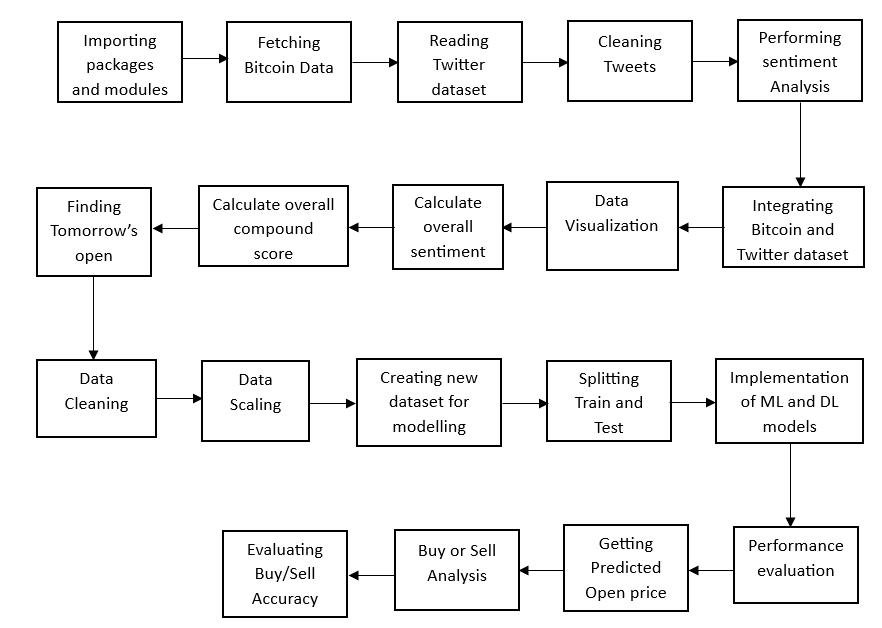

# Installing Packages


*   mplfinance -> To create candlestick charts and other financial plots.
*   vaderSentiment -> For sentiment analysis tasks.



In [1]:
pip install mplfinance

In [2]:
pip install vaderSentiment

# Importing Modules
Importing various modules for various tasks including natural language processing, machine learning, visualization, and sentiment analysis.

In [3]:
#Importing Modules
import nltk
import re
import requests
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from keras import layers
from sklearn import metrics
from textblob import TextBlob
from keras.layers import Input, LSTM, Dense, GRU
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, confusion_matrix

# Fetching Bitcoin data
A function to fetch historical Bitcoin data from **api.coindesk.com** within a specified date range and formats it into a DataFrame and save the DataFrame to a CSV file named "**cryptodata.csv**".

In [4]:
def get_bitcoin_data(from_date, to_date):
    api_url = f"https://api.coindesk.com/v1/bpi/historical/ohlcv.json?start={from_date}&end={to_date}"
    response = requests.get(api_url)
    data = response.json()['bpi']
    # Extracting relevant data and creating a DataFrame
    bitcoin_data = pd.DataFrame(data.values(), index=data.keys(), columns=['open', 'high', 'low', 'close'])
    # Add a 'date' column to the DataFrame
    bitcoin_data['date'] = pd.to_datetime(bitcoin_data.index)
    # Reorder the columns
    bitcoin_data = bitcoin_data[['date', 'open', 'high', 'low', 'close']]
    return bitcoin_data

df_bitcoin = get_bitcoin_data('2021-02-01', '2023-06-12')
df_bitcoin = df_bitcoin.reset_index(drop=True)
df_bitcoin.to_csv('cryptodata.csv', index=False)  # Don't include index in CSV
df_bitcoin

date        open        high         low       close
0   2021-02-01  33138.7765  34715.6557  32341.9899  33613.3208
1   2021-02-02  33525.2882  36008.3108  33437.7469  35632.9020
2   2021-02-03  35519.7078  37505.3037  35416.7318  37397.4264
3   2021-02-04  37645.9456  38731.0880  36207.4943  37256.2521
4   2021-02-05  36970.8123  38332.4169  36637.6456  37851.5966
..         ...         ...         ...         ...         ...
853 2023-06-08  26323.8511  26717.8448  26225.8423  26600.3653
854 2023-06-09  26498.5902  26770.2167  26319.0688  26460.5807
855 2023-06-10  26475.2106  26522.0733  25449.2555  25950.5441
856 2023-06-11  25865.7598  26218.0278  25671.2924  25809.0986
857 2023-06-12  25930.9289  26090.4699  25661.7685  25891.9343

[858 rows x 5 columns]

# Importing Twitter Dataset
The social media data related to bitcoin discussions are imported.

In [5]:
!gdown https://drive.google.com/uc?id=1KBsZ9SgtsT2M4Hf3anZ9-WTZHXWnWZWT
#Read twitter dataset
df_tweet = pd.read_csv('tweet.csv')
df_tweet

Downloading...
From: https://drive.google.com/uc?id=1KBsZ9SgtsT2M4Hf3anZ9-WTZHXWnWZWT
To: /content/tweet.csv
100% 1.25M/1.25M [00:00<00:00, 103MB/s]


created_at  favorite_count  \
0      2/1/2021             154   
1      2/1/2021              17   
2      2/1/2021               3   
3      2/1/2021               0   
4      2/1/2021               7   
...         ...             ...   
6559  6/12/2023               0   
6560  6/12/2023              38   
6561  6/12/2023               0   
6562  6/12/2023               1   
6563  6/12/2023              56   

                                              full_text  reply_count  \
0     #privacy is a human right. learn how to make y...           18   
1     overall btc trading volume has increased, but ...            1   
2     on average, the return distribution of btc ske...            0   
3     rt @reg_mati: la privacidad es un derecho huma...            0   
4     the grayscale premium represents the differenc...            0   
...                                                 ...          ...   
6559  rt @crypto_crib_: ðbitcoin miners are depos...            0   
6560  theyâve been trying, but i have nothing unde...           12   
6561  rt @crypto_crib_: peter brandt claims that exc...            0   
6562  new gap cme - 26400 ð\n\nno better time to ...            9   
6563      bitcoin, not crypto.\n\ncrypto, not security.           16   

      retweet_count  
0                23  
1                 5  
2                 1  
3                 7  
4                 2  
...             ...  
6559             10  
6560              2  
6561              6  
6562              0  
6563              7  

[6564 rows x 5 columns]

# Cleaning the tweets
lCeans the tweets by performing several preprocessing steps such as converting text to lowercase, removing mentions, hashtags, URLs, punctuation, square brackets and their content, non-alphanumeric characters, and stopwords. The cleaned tweets are stored in a new column called 'cleaned_tweets' in the DataFrame df_tweet.

In [6]:
#Cleaning the tweets
nltk.download('stopwords') # Download stopwords
stopword = nltk.corpus.stopwords.words('english') # Load stopwords
print(stopword)# Print all the stopwords
def clean_tweet(text):
    text = text.lower()# Convert text to lowercase
    text = re.sub("@[A-Za-z0-9_]+", "", text) # Remove mentions
    text = re.sub("#[A-Za-z0-9_]+", "", text)# Remove hashtags
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r"www.\S+", "", text)    # Remove URLs starting with 'www'
    text = re.sub('[()!?]', ' ', text)    # Remove punctuation
    text = re.sub('\[.*?\]', ' ', text)    # Remove square brackets and content within the
    text = re.sub("[^a-z0-9]", " ", text)     # Remove non-alphanumeric characters
    text = text.split()     # Tokenize text
    text = [word for word in text if word not in stopword]     # Remove stopwords
    text = " ".join(text)    # Join tokens back into text
    text = re.sub('\\n', '', text)    # Remove '\n'
    return text

# Apply the cleaning function to the 'full_text' column and create a new column 'cleaned_tweets'
df_tweet['cleaned_tweets'] = df_tweet['full_text'].apply(clean_tweet)
# Display the DataFrame with cleaned tweets
df_tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

created_at  favorite_count  \
0      2/1/2021             154   
1      2/1/2021              17   
2      2/1/2021               3   
3      2/1/2021               0   
4      2/1/2021               7   
...         ...             ...   
6559  6/12/2023               0   
6560  6/12/2023              38   
6561  6/12/2023               0   
6562  6/12/2023               1   
6563  6/12/2023              56   

                                              full_text  reply_count  \
0     #privacy is a human right. learn how to make y...           18   
1     overall btc trading volume has increased, but ...            1   
2     on average, the return distribution of btc ske...            0   
3     rt @reg_mati: la privacidad es un derecho huma...            0   
4     the grayscale premium represents the differenc...            0   
...                                                 ...          ...   
6559  rt @crypto_crib_: ðbitcoin miners are depos...            0   
6560  theyâve been trying, but i have nothing unde...           12   
6561  rt @crypto_crib_: peter brandt claims that exc...            0   
6562  new gap cme - 26400 ð\n\nno better time to ...            9   
6563      bitcoin, not crypto.\n\ncrypto, not security.           16   

      retweet_count                                     cleaned_tweets  
0                23   human right learn make transactions private clip  
1                 5  overall btc trading volume increased average t...  
2                 1  average return distribution btc skews slightly...  
3                 7  rt la privacidad es un derecho humano mir el v...  
4                 2  grayscale premium represents difference market...  
...             ...                                                ...  
6559             10  rt bitcoin miners depositing btc exchanges jun...  
6560              2  trying nothing name usa moved business early 9...  
6561              6  rt peter brandt claims except bitcoin cryptocu...  
6562              0  new gap cme 26400 better time join 60 click bt...  
6563              7                     bitcoin crypto crypto security  

[6564 rows x 6 columns]

# Sentiment Analysis using VADER
Performs sentiment analysis on the cleaned tweets using VADER (Valence Aware Dictionary and sEntiment Reasoner). It calculates sentiment scores for each tweet and assigns sentiment labels (positive, negative, or neutral) based on the compound score. The sentiment scores and labels are then added to the original DataFrame df_tweet.

In [7]:
#Sentiment Analysis
nltk.download('vader_lexicon')  # Download the VADER lexicon
analyzer = SentimentIntensityAnalyzer()# Initialize the SentimentIntensityAnalyzer
scores = []# Initialize an empty list to store the sentiment scores

# Define the get_sentiment function to assign sentiment labels
def get_sentiment(row):
  if row['compound'] > 0:
        return 'positive'
  elif row['compound'] <0:
        return 'negative'
  else:
        return 'neutral'
for tweet in df_tweet['cleaned_tweets']:
    sentiment_scores = analyzer.polarity_scores(tweet)  # Calculate the sentiment scores for the tweet
    scores.append(sentiment_scores)    # Append the scores to the list

# Convert the list of scores to a DataFrame
sentiments_df = pd.DataFrame(scores)
# Join the sentiment scores DataFrame with the original DataFrame df_tweet
df_tweet = pd.concat([df_tweet, sentiments_df], axis=1)
df_tweet['compound_score'] = df_tweet['compound']
# Combine the 'compound', 'neu', 'neg', and 'pos' values into a dictionary column named 'score'
df_tweet['score'] = df_tweet[['neu', 'neg', 'pos']].apply(lambda x: dict(x), axis=1)
# Add a column to store the text sentiment based on 'pos', 'neg', and 'neu' values
df_tweet['sentiment_vader'] = df_tweet.apply(get_sentiment, axis=1)
df_tweet.drop(columns=['compound', 'neu', 'neg', 'pos'], inplace=True)
df_tweet


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


created_at  favorite_count  \
0      2/1/2021             154   
1      2/1/2021              17   
2      2/1/2021               3   
3      2/1/2021               0   
4      2/1/2021               7   
...         ...             ...   
6559  6/12/2023               0   
6560  6/12/2023              38   
6561  6/12/2023               0   
6562  6/12/2023               1   
6563  6/12/2023              56   

                                              full_text  reply_count  \
0     #privacy is a human right. learn how to make y...           18   
1     overall btc trading volume has increased, but ...            1   
2     on average, the return distribution of btc ske...            0   
3     rt @reg_mati: la privacidad es un derecho huma...            0   
4     the grayscale premium represents the differenc...            0   
...                                                 ...          ...   
6559  rt @crypto_crib_: ðbitcoin miners are depos...            0   
6560  theyâve been trying, but i have nothing unde...           12   
6561  rt @crypto_crib_: peter brandt claims that exc...            0   
6562  new gap cme - 26400 ð\n\nno better time to ...            9   
6563      bitcoin, not crypto.\n\ncrypto, not security.           16   

      retweet_count                                     cleaned_tweets  \
0                23   human right learn make transactions private clip   
1                 5  overall btc trading volume increased average t...   
2                 1  average return distribution btc skews slightly...   
3                 7  rt la privacidad es un derecho humano mir el v...   
4                 2  grayscale premium represents difference market...   
...             ...                                                ...   
6559             10  rt bitcoin miners depositing btc exchanges jun...   
6560              2  trying nothing name usa moved business early 9...   
6561              6  rt peter brandt claims except bitcoin cryptocu...   
6562              0  new gap cme 26400 better time join 60 click bt...   
6563              7                     bitcoin crypto crypto security   

      compound_score                                       score  \
0             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
1             0.2732      {'neu': 0.89, 'neg': 0.0, 'pos': 0.11}   
2             0.5729  {'neu': 0.582, 'neg': 0.149, 'pos': 0.269}   
3             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
4             0.2960   {'neu': 0.81, 'neg': 0.074, 'pos': 0.116}   
...              ...                                         ...   
6559          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6560          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6561         -0.4939    {'neu': 0.775, 'neg': 0.225, 'pos': 0.0}   
6562          0.6249    {'neu': 0.841, 'neg': 0.0, 'pos': 0.159}   
6563          0.3400    {'neu': 0.556, 'neg': 0.0, 'pos': 0.444}   

     sentiment_vader  
0            neutral  
1           positive  
2           positive  
3            neutral  
4           positive  
...              ...  
6559         neutral  
6560         neutral  
6561        negative  
6562        positive  
6563        positive  

[6564 rows x 9 columns]

# Sentiment Analysis using TextBlob
TextBlob to analyze sentiment in tweets, assigning polarity and subjectivity scores, and then categorizing sentiment into positive, negative, or neutral labels based on polarity.

In [8]:
# Define the function to analyze sentiment using TextBlob
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Apply sentiment analysis using TextBlob
df_tweet['polarity'], df_tweet['subjectivity'] = zip(*df_tweet['cleaned_tweets'].apply(analyze_sentiment))

# Define the function to assign sentiment labels
def get_sentiment_label(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'
# Apply sentiment label
df_tweet['sentiment_textblob'] = df_tweet['polarity'].apply(get_sentiment_label)
df_tweet

created_at  favorite_count  \
0      2/1/2021             154   
1      2/1/2021              17   
2      2/1/2021               3   
3      2/1/2021               0   
4      2/1/2021               7   
...         ...             ...   
6559  6/12/2023               0   
6560  6/12/2023              38   
6561  6/12/2023               0   
6562  6/12/2023               1   
6563  6/12/2023              56   

                                              full_text  reply_count  \
0     #privacy is a human right. learn how to make y...           18   
1     overall btc trading volume has increased, but ...            1   
2     on average, the return distribution of btc ske...            0   
3     rt @reg_mati: la privacidad es un derecho huma...            0   
4     the grayscale premium represents the differenc...            0   
...                                                 ...          ...   
6559  rt @crypto_crib_: ðbitcoin miners are depos...            0   
6560  theyâve been trying, but i have nothing unde...           12   
6561  rt @crypto_crib_: peter brandt claims that exc...            0   
6562  new gap cme - 26400 ð\n\nno better time to ...            9   
6563      bitcoin, not crypto.\n\ncrypto, not security.           16   

      retweet_count                                     cleaned_tweets  \
0                23   human right learn make transactions private clip   
1                 5  overall btc trading volume increased average t...   
2                 1  average return distribution btc skews slightly...   
3                 7  rt la privacidad es un derecho humano mir el v...   
4                 2  grayscale premium represents difference market...   
...             ...                                                ...   
6559             10  rt bitcoin miners depositing btc exchanges jun...   
6560              2  trying nothing name usa moved business early 9...   
6561              6  rt peter brandt claims except bitcoin cryptocu...   
6562              0  new gap cme 26400 better time join 60 click bt...   
6563              7                     bitcoin crypto crypto security   

      compound_score                                       score  \
0             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
1             0.2732      {'neu': 0.89, 'neg': 0.0, 'pos': 0.11}   
2             0.5729  {'neu': 0.582, 'neg': 0.149, 'pos': 0.269}   
3             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
4             0.2960   {'neu': 0.81, 'neg': 0.074, 'pos': 0.116}   
...              ...                                         ...   
6559          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6560          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6561         -0.4939    {'neu': 0.775, 'neg': 0.225, 'pos': 0.0}   
6562          0.6249    {'neu': 0.841, 'neg': 0.0, 'pos': 0.159}   
6563          0.3400    {'neu': 0.556, 'neg': 0.0, 'pos': 0.444}   

     sentiment_vader  polarity  subjectivity sentiment_textblob  
0            neutral  0.095238      0.336905           positive  
1           positive -0.050000      0.133333           negative  
2           positive  0.153068      0.590114           positive  
3            neutral  0.000000      0.000000            neutral  
4           positive -0.100000      0.322222           negative  
...              ...       ...           ...                ...  
6559         neutral  0.000000      0.000000            neutral  
6560         neutral  0.175000      0.316667           positive  
6561        negative  0.000000      0.000000            neutral  
6562        positive  0.212121      0.651515           positive  
6563        positive  0.000000      0.000000            neutral  

[6564 rows x 12 columns]

 # Bar chart to show the sentiments
Bar chart to visualize sentiment analysis results.

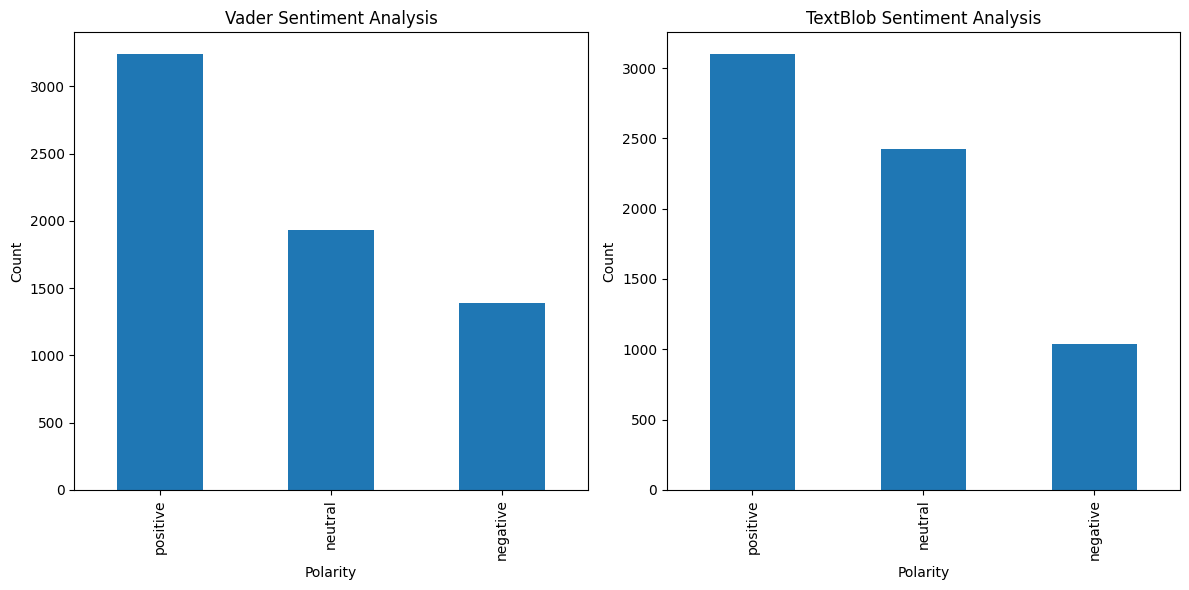

In [9]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sentiment analysis results for Vader
df_tweet['sentiment_vader'].value_counts().plot(kind="bar", ax=axes[0])
axes[0].set_title("Vader Sentiment Analysis")
axes[0].set_xlabel("Polarity")
axes[0].set_ylabel("Count")

# Plot sentiment analysis results for TextBlob
df_tweet['sentiment_textblob'].value_counts().plot(kind="bar", ax=axes[1])
axes[1].set_title("TextBlob Sentiment Analysis")
axes[1].set_xlabel("Polarity")
axes[1].set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()


#	Integrating sentiment analysis data with cryptocurrency price data
Merging two DataFrames based on a common column ('date') to integrate sentiment analysis data with cryptocurrency price data.


In [10]:
df_tweet.rename(columns={'created_at': 'date'}, inplace=True)
df_tweet['date'] = pd.to_datetime(df_tweet['date'])
merged_df = pd.merge(df_tweet, df_bitcoin, on='date', how='inner')
merged_df


date  favorite_count  \
0    2021-02-01             154   
1    2021-02-01              17   
2    2021-02-01               3   
3    2021-02-01               0   
4    2021-02-01               7   
...         ...             ...   
6546 2023-06-12               0   
6547 2023-06-12              38   
6548 2023-06-12               0   
6549 2023-06-12               1   
6550 2023-06-12              56   

                                              full_text  reply_count  \
0     #privacy is a human right. learn how to make y...           18   
1     overall btc trading volume has increased, but ...            1   
2     on average, the return distribution of btc ske...            0   
3     rt @reg_mati: la privacidad es un derecho huma...            0   
4     the grayscale premium represents the differenc...            0   
...                                                 ...          ...   
6546  rt @crypto_crib_: ðbitcoin miners are depos...            0   
6547  theyâve been trying, but i have nothing unde...           12   
6548  rt @crypto_crib_: peter brandt claims that exc...            0   
6549  new gap cme - 26400 ð\n\nno better time to ...            9   
6550      bitcoin, not crypto.\n\ncrypto, not security.           16   

      retweet_count                                     cleaned_tweets  \
0                23   human right learn make transactions private clip   
1                 5  overall btc trading volume increased average t...   
2                 1  average return distribution btc skews slightly...   
3                 7  rt la privacidad es un derecho humano mir el v...   
4                 2  grayscale premium represents difference market...   
...             ...                                                ...   
6546             10  rt bitcoin miners depositing btc exchanges jun...   
6547              2  trying nothing name usa moved business early 9...   
6548              6  rt peter brandt claims except bitcoin cryptocu...   
6549              0  new gap cme 26400 better time join 60 click bt...   
6550              7                     bitcoin crypto crypto security   

      compound_score                                       score  \
0             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
1             0.2732      {'neu': 0.89, 'neg': 0.0, 'pos': 0.11}   
2             0.5729  {'neu': 0.582, 'neg': 0.149, 'pos': 0.269}   
3             0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
4             0.2960   {'neu': 0.81, 'neg': 0.074, 'pos': 0.116}   
...              ...                                         ...   
6546          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6547          0.0000        {'neu': 1.0, 'neg': 0.0, 'pos': 0.0}   
6548         -0.4939    {'neu': 0.775, 'neg': 0.225, 'pos': 0.0}   
6549          0.6249    {'neu': 0.841, 'neg': 0.0, 'pos': 0.159}   
6550          0.3400    {'neu': 0.556, 'neg': 0.0, 'pos': 0.444}   

     sentiment_vader  polarity  subjectivity sentiment_textblob        open  \
0            neutral  0.095238      0.336905           positive  33138.7765   
1           positive -0.050000      0.133333           negative  33138.7765   
2           positive  0.153068      0.590114           positive  33138.7765   
3            neutral  0.000000      0.000000            neutral  33138.7765   
4           positive -0.100000      0.322222           negative  33138.7765   
...              ...       ...           ...                ...         ...   
6546         neutral  0.000000      0.000000            neutral  25930.9289   
6547         neutral  0.175000      0.316667           positive  25930.9289   
6548        negative  0.000000      0.000000            neutral  25930.9289   
6549        positive  0.212121      0.651515           positive  25930.9289   
6550        positive  0.000000      0.000000            neutral  25930.9289   

            high         low       close  
0     34715.6557  32341.989

# Data Visualization
Plots a candlestick chart using the mplfinance library. This chart will help you understand the change in the bitcoin price during the particular interval of time, green bullish (positive) candlestick indicates closing price is higher than the opening price whereas, red bearish (negative) candlestick indicates the closing price is lower than the opening price.

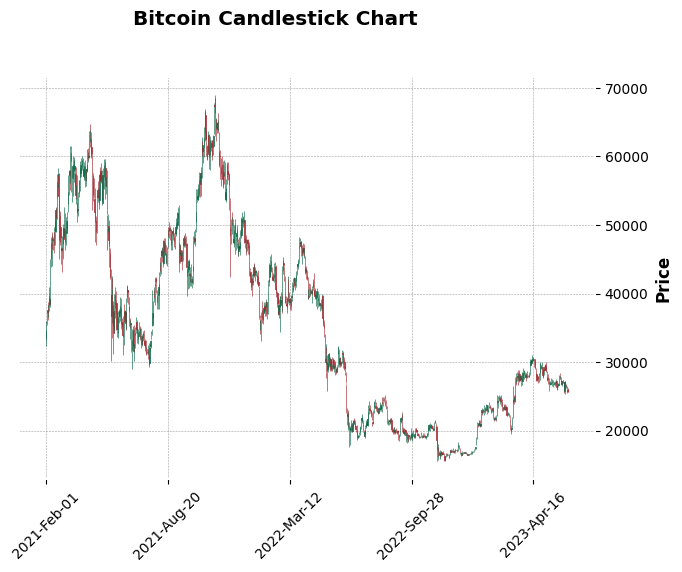

In [11]:
# Set the 'date' column as the index
df_bitcoin.set_index('date', inplace=True)
# Plot the candlestick chart
mpf.plot(df_bitcoin, type='candle', style='charles', title='Bitcoin Candlestick Chart', ylabel='Price', warn_too_much_data=10000)

# Bitcoin price movements along with trends
The moving averages (MA) for Bitcoin prices are calculated for 20, 50, and 200 days and plotted using Matplotlib.

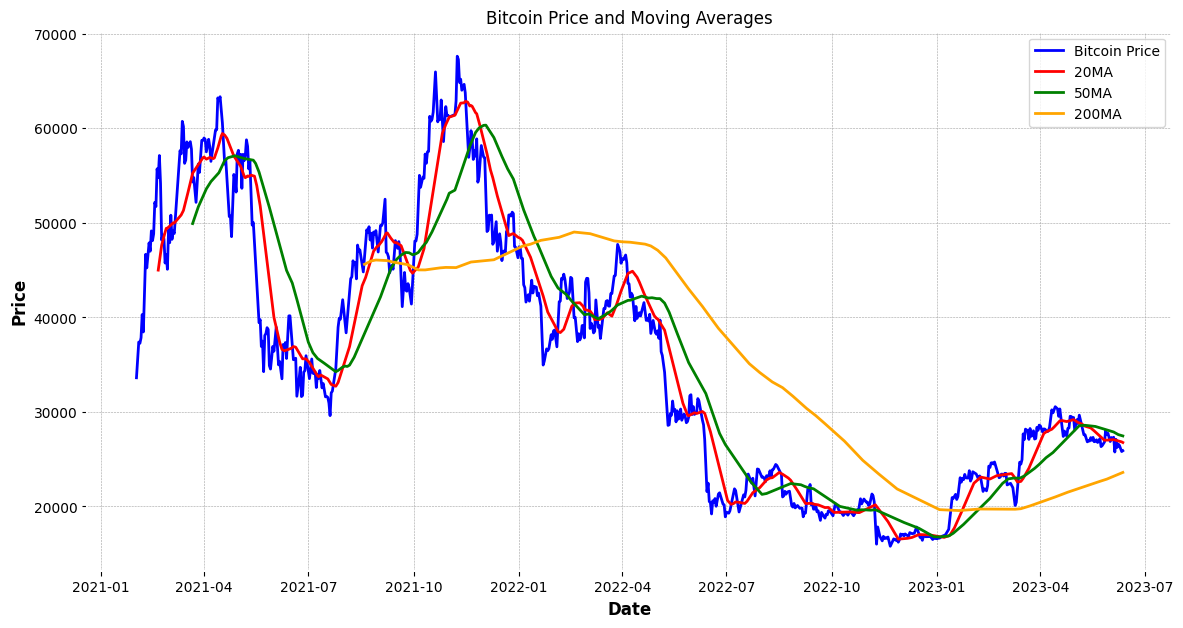

In [12]:
# Calculate moving averages
df_bitcoin['20MA'] = df_bitcoin['close'].rolling(window=20).mean() #short-term outlook
df_bitcoin['50MA'] = df_bitcoin['close'].rolling(window=50).mean() #Medium term outlook
df_bitcoin['200MA'] = df_bitcoin['close'].rolling(window=200).mean() #trend bias

# Plot the Bitcoin price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(df_bitcoin.index, df_bitcoin['close'], label='Bitcoin Price', color='blue')
plt.plot(df_bitcoin.index, df_bitcoin['20MA'], label='20MA', color='red')
plt.plot(df_bitcoin.index, df_bitcoin['50MA'], label='50MA', color='green')
plt.plot(df_bitcoin.index, df_bitcoin['200MA'], label='200MA', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price and Moving Averages')
plt.legend()

# Show plot
plt.show()
df_bitcoin.drop(columns=[ '20MA', '50MA', '200MA'], inplace=True)

# Overview of the dataset's characteristics
Print the shape (number of rows, number of columns), columns or features names, distribution of labels based on the 'sentiment' column, and general information of the dataset, including the data types of each column and memory usage.



In [13]:
print("Shape of dataset", merged_df.shape) #Dimension of dataset
print("\nColumns of dataset:", merged_df.columns)  # List of columns
print("\nDistribution of Vader Label", merged_df.groupby('sentiment_vader').size()) # Label Distribution
print("\nDistribution of Textblob Label", merged_df.groupby('sentiment_textblob').size()) # Label Distribution
print("\nInformation of dataset")
merged_df.info()

Shape of dataset (6551, 16)

Columns of dataset: Index(['date', 'favorite_count', 'full_text', 'reply_count', 'retweet_count',
       'cleaned_tweets', 'compound_score', 'score', 'sentiment_vader',
       'polarity', 'subjectivity', 'sentiment_textblob', 'open', 'high', 'low',
       'close'],
      dtype='object')

Distribution of Vader Label sentiment_vader
negative    1389
neutral     1930
positive    3232
dtype: int64

Distribution of Textblob Label sentiment_textblob
negative    1036
neutral     2420
positive    3095
dtype: int64

Information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6551 entries, 0 to 6550
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                6551 non-null   datetime64[ns]
 1   favorite_count      6551 non-null   int64         
 2   full_text           6551 non-null   object        
 3   reply_count         6551 non-null   int64  

# Summary statistics
Print out the summary statistics of numerical columns in the merged DataFrame, including count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile), 75th percentile (Q3), and maximum values for each numerical column. It will help to understand the distribution and characteristics of numerical features in your dataset.

In [14]:
print("\nSummary statistics of numerical columns:")
merged_df.describe()



Summary statistics of numerical columns:


date  favorite_count  reply_count  \
count                           6551     6551.000000  6551.000000   
mean   2022-12-10 04:27:17.612578048      827.876965   102.474279   
min              2021-02-01 00:00:00        0.000000     0.000000   
25%              2022-10-21 12:00:00       18.000000     3.000000   
50%              2023-03-17 00:00:00      133.000000    27.000000   
75%              2023-05-07 00:00:00      602.000000   102.000000   
max              2023-06-12 00:00:00   286955.000000  4876.000000   
std                              NaN     3987.506810   239.566078   

       retweet_count  compound_score     polarity  subjectivity          open  \
count    6551.000000     6551.000000  6551.000000   6551.000000   6551.000000   
mean      166.140589        0.155339     0.083670      0.331063  28766.266662   
min         0.000000       -0.942300    -1.000000      0.000000  15758.440400   
25%         8.000000        0.000000     0.000000      0.000000  23467.148000   
50%        24.000000        0.000000     0.000000      0.333333  27213.765700   
75%       112.000000        0.458800     0.175000      0.512500  29275.011200   
max     53147.000000        0.982900     1.000000      1.000000  67539.791200   
std       767.780465        0.408089     0.211918      0.280408   9302.115584   

               high           low         close  
count   6551.000000   6551.000000   6551.000000  
mean   29445.114626  28128.674199  28831.489790  
min    16263.173900  15586.318900  15791.075500  
25%    24204.006900  23040.774100  23670.436300  
50%    27626.224000  26774.651200  27164.915900  
75%    29991.204200  28719.779500  29510.477700  
max    68954.285900  66311.880100  67633.647700  
std     9562.279030   8960.740029   9278.819074

# Generate word cloud
Download English stopwords and preprocess the text data, including removing stopwords, and generate word clouds before and after preprocessing to visualize the changes.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before Data Preprocessing


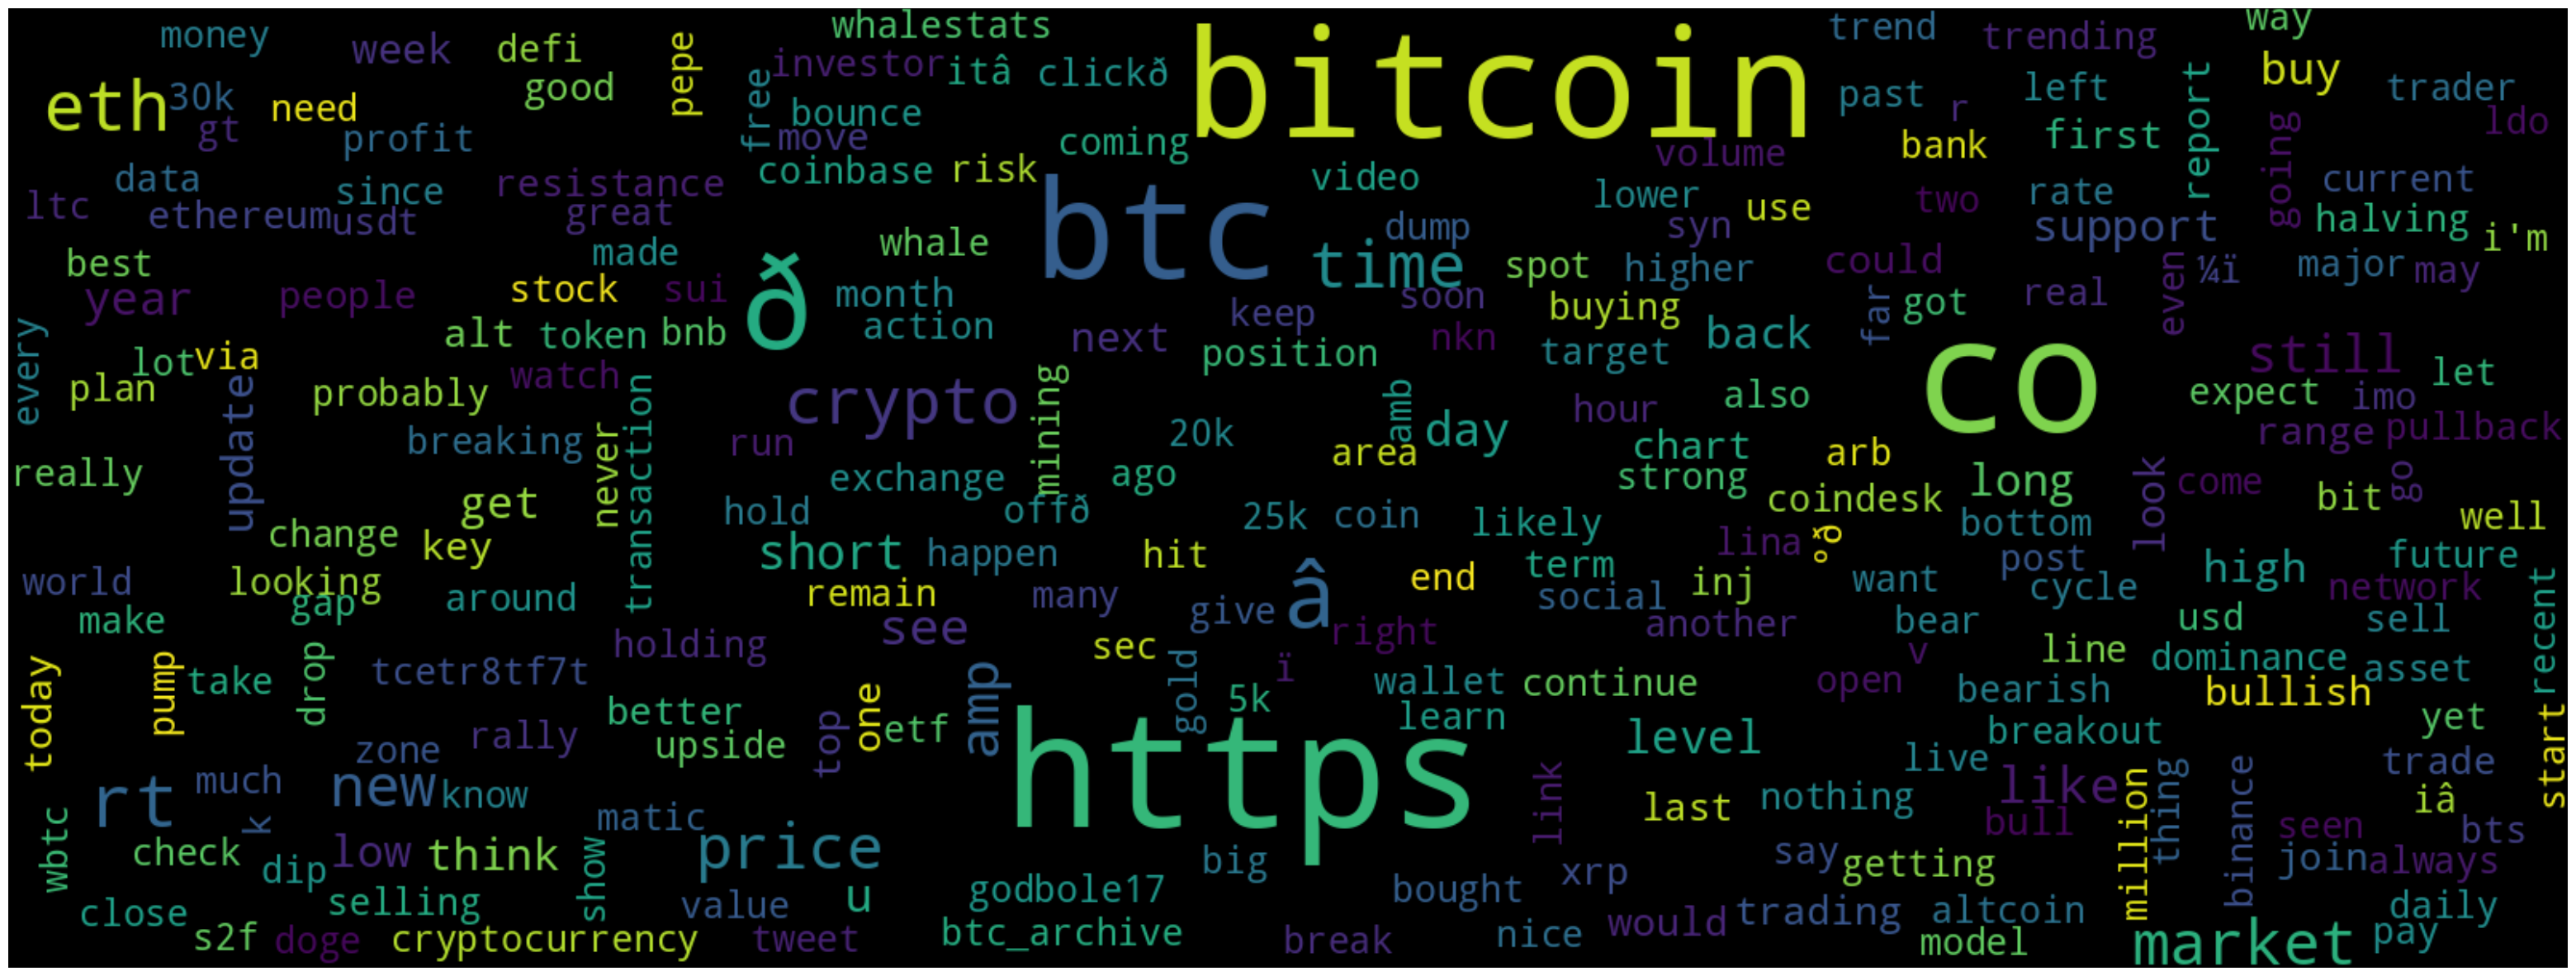


After Data Preprocessing


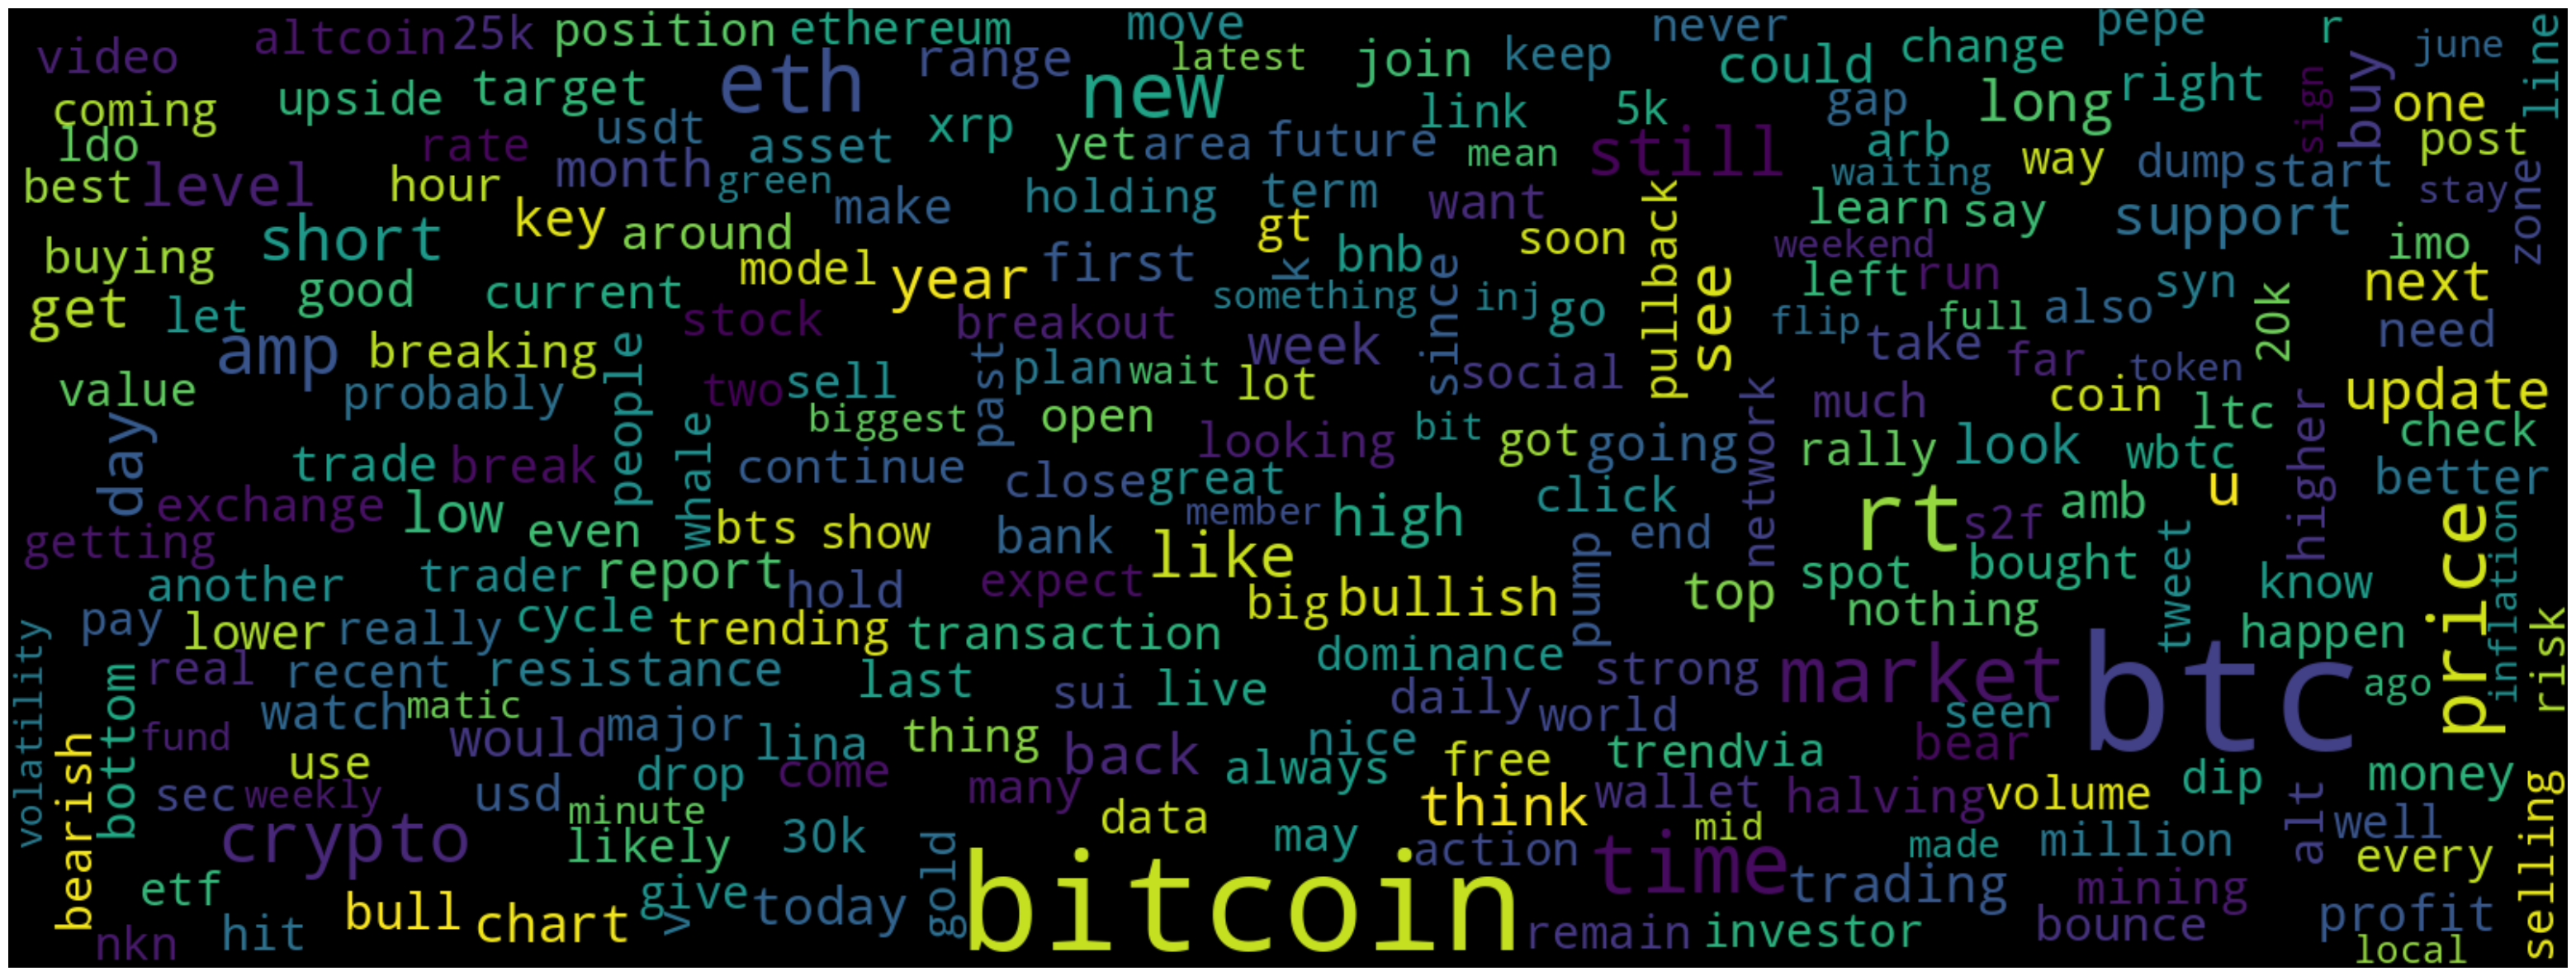

In [15]:
nltk.download('stopwords')# Download stopwords
stopwords = stopwords.words('english')# Get the English stopwords directly

print("Before Data Preprocessing")
merged_df['full_text'] = merged_df['full_text'].astype(str)
# Concatenate the text data
string = merged_df['full_text'].str.cat(sep=' ')
# Generate word cloud
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=600, max_font_size=100, max_words=250, collocations=False).generate(string)

# Plot word cloud
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("\nAfter Data Preprocessing")
merged_df['cleaned_tweets'] = merged_df['cleaned_tweets'].astype(str)
# Concatenate the text data
string = merged_df['cleaned_tweets'].str.cat(sep=' ')
# Generate word cloud
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=600, max_font_size=100, max_words=250, collocations=False).generate(string)

# Plot word cloud
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Histogram
Creating histograms for numerical variables ('open', 'high', 'low', 'close') in your DataFrame, each displayed in a subplot.

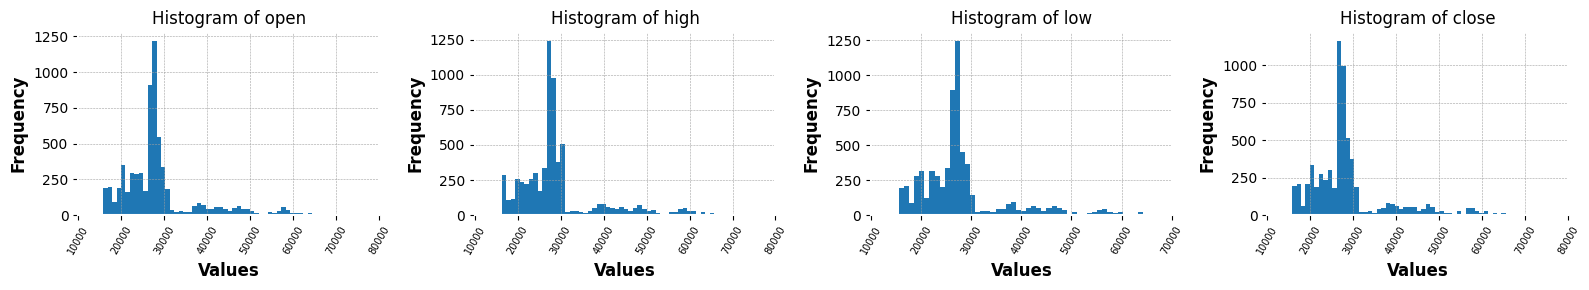

In [16]:
# Histogram for a numerical variable
hist= [ 'open', 'high','low','close']
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
axs = axs.flatten()
for i, feature in enumerate(hist):
    ax = axs.flatten()[i]
    ax.hist(merged_df[feature], bins=50)
    ax.set_title("Histogram of "+feature)
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequency")
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=7)
plt.tight_layout()
plt.show()


# Calculate overall sentiment of a day
Calculate the overall sentiment for each date based on the grouped sentiments for VADER and TextBlob features, merge it back into the original DataFrame, rename the new column to sentiment_vader_overall and	sentiment_textblob_overall, and drop some unnecessary features.

In [17]:
# Function to calculate overall sentiment
def calculate_overall_sentiment(sentiments):
    positive_count = sentiments.count('positive')
    negative_count = sentiments.count('negative')
    neutral_count = sentiments.count('neutral')

    if positive_count > negative_count and positive_count > neutral_count:
        return 'positive'
    elif negative_count > positive_count and negative_count > neutral_count:
        return 'negative'
    else:
        return 'neutral'

# Group sentiments by date and calculate overall sentiment
overall_sentiments_vader = merged_df.groupby('date')['sentiment_vader'].apply(list).apply(calculate_overall_sentiment)
# Merge overall sentiments with the original DataFrame
merged_df = pd.merge(merged_df, overall_sentiments_vader, on='date', suffixes=('', '_overall'))
merged_df.rename(columns={'sentiment_overall_vader': 'Overall_vader'}, inplace=True) # Rename the new column
# Group sentiments by date and calculate overall sentiment
overall_sentiments_textblob = merged_df.groupby('date')['sentiment_textblob'].apply(list).apply(calculate_overall_sentiment)
# Merge overall sentiments with the original DataFrame
merged_df = pd.merge(merged_df, overall_sentiments_textblob, on='date', suffixes=('', '_overall'))
merged_df.rename(columns={'sentiment_overall_textblob': 'Overall_textblob'}, inplace=True) # Rename the new column
# Define features to remove
features_to_remove = ['favorite_count', 'full_text', 'reply_count', 'retweet_count', 'cleaned_tweets', 'score', 'sentiment_textblob','sentiment_vader','subjectivity']
merged_df = merged_df.drop(columns=features_to_remove)# Drop the specified features
merged_df


date  compound_score  polarity        open        high         low  \
0    2021-02-01          0.0000  0.095238  33138.7765  34715.6557  32341.9899   
1    2021-02-01          0.2732 -0.050000  33138.7765  34715.6557  32341.9899   
2    2021-02-01          0.5729  0.153068  33138.7765  34715.6557  32341.9899   
3    2021-02-01          0.0000  0.000000  33138.7765  34715.6557  32341.9899   
4    2021-02-01          0.2960 -0.100000  33138.7765  34715.6557  32341.9899   
...         ...             ...       ...         ...         ...         ...   
6546 2023-06-12          0.0000  0.000000  25930.9289  26090.4699  25661.7685   
6547 2023-06-12          0.0000  0.175000  25930.9289  26090.4699  25661.7685   
6548 2023-06-12         -0.4939  0.000000  25930.9289  26090.4699  25661.7685   
6549 2023-06-12          0.6249  0.212121  25930.9289  26090.4699  25661.7685   
6550 2023-06-12          0.3400  0.000000  25930.9289  26090.4699  25661.7685   

           close sentiment_vader_overall sentiment_textblob_overall  
0     33613.3208                 neutral                    neutral  
1     33613.3208                 neutral                    neutral  
2     33613.3208                 neutral                    neutral  
3     33613.3208                 neutral                    neutral  
4     33613.3208                 neutral                    neutral  
...          ...                     ...                        ...  
6546  25891.9343                positive                   positive  
6547  25891.9343                positive                   positive  
6548  25891.9343                positive                   positive  
6549  25891.9343                positive                   positive  
6550  25891.9343                positive                   positive  

[6551 rows x 9 columns]

# Calculate overall compound score
Calculates the overall compound score and polarity for each date, merges it back into the original DataFrame, renames the new column to 'Overall_Compound_Score' and 'polarity_overall', drops the specified features, and removes any identical or duplicate rows in the DataFrame.

In [18]:
# Function to calculate overall compound score
def calculate_overall_score(scores):
    overall_compound = scores.mean()
    return overall_compound

# Group compound scores by date and calculate overall compound score
overall_compound_scores = merged_df.groupby('date')['compound_score'].agg(calculate_overall_score)
# Merge overall compound scores with the original DataFrame
merged_df = pd.merge(merged_df, overall_compound_scores, on='date', suffixes=('', '_overall'))
# Rename the new column
merged_df.rename(columns={'compound_score_overall': 'Overall_Compound_Score'}, inplace=True)
# Group compound scores by date and calculate overall polarity
overall_polarity = merged_df.groupby('date')['polarity'].agg(calculate_overall_score)
# Merge overall compound scores with the original DataFrame
merged_df = pd.merge(merged_df, overall_polarity, on='date', suffixes=('', '_overall'))
# Rename the new column
merged_df.rename(columns={'compound_polarity': 'Overall_polarity'}, inplace=True)
# Drop the specified features
merged_df = merged_df.drop(columns=['compound_score','polarity'])# Drop the specified features
#Removing identical rows
merged_df.drop_duplicates(inplace=True)
merged_df


date        open        high         low       close  \
0    2021-02-01  33138.7765  34715.6557  32341.9899  33613.3208   
7    2021-02-02  33525.2882  36008.3108  33437.7469  35632.9020   
11   2021-02-03  35519.7078  37505.3037  35416.7318  37397.4264   
15   2021-02-04  37645.9456  38731.0880  36207.4943  37256.2521   
18   2021-02-05  36970.8123  38332.4169  36637.6456  37851.5966   
...         ...         ...         ...         ...         ...   
6325 2023-06-08  26323.8511  26717.8448  26225.8423  26600.3653   
6371 2023-06-09  26498.5902  26770.2167  26319.0688  26460.5807   
6429 2023-06-10  26475.2106  26522.0733  25449.2555  25950.5441   
6484 2023-06-11  25865.7598  26218.0278  25671.2924  25809.0986   
6507 2023-06-12  25930.9289  26090.4699  25661.7685  25891.9343   

     sentiment_vader_overall sentiment_textblob_overall  \
0                    neutral                    neutral   
7                   positive                   positive   
11                  positive                   positive   
15                  positive                    neutral   
18                  positive                   positive   
...                      ...                        ...   
6325                positive                   positive   
6371                positive                   positive   
6429                positive                   positive   
6484                positive                   positive   
6507                positive                   positive   

      Overall_Compound_Score  polarity_overall  
0                   0.163157          0.014044  
7                   0.374750          0.000833  
11                  0.415050          0.100000  
15                  0.232633         -0.025000  
18                  0.254378          0.113717  
...                      ...               ...  
6325                0.202759          0.107849  
6371                0.372647          0.131593  
6429                0.264084          0.101433  
6484                0.385339          0.060175  
6507                0.233848          0.105477  

[779 rows x 9 columns]

 # Bar chart to show the sentiments
Bar chart to visualize sentiment analysis results after calculating the overall sentiment.

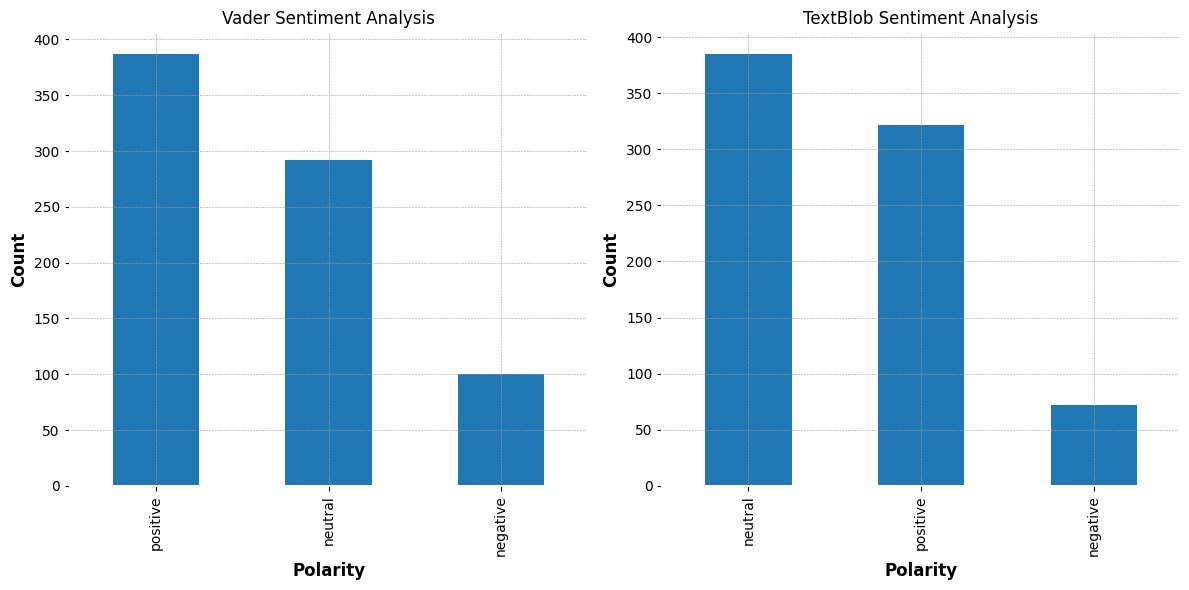

In [19]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sentiment analysis results for Vader
merged_df['sentiment_vader_overall'].value_counts().plot(kind="bar", ax=axes[0])
axes[0].set_title("Vader Sentiment Analysis")
axes[0].set_xlabel("Polarity")
axes[0].set_ylabel("Count")

# Plot sentiment analysis results for TextBlob
merged_df['sentiment_textblob_overall'].value_counts().plot(kind="bar", ax=axes[1])
axes[1].set_title("TextBlob Sentiment Analysis")
axes[1].set_xlabel("Polarity")
axes[1].set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()


In [20]:
print("\nDistribution of Vader Label", merged_df.groupby('sentiment_vader_overall').size()) # Label Distribution
print("\nDistribution of Textblob Label", merged_df.groupby('sentiment_textblob_overall').size()) # Label Distribution


Distribution of Vader Label sentiment_vader_overall
negative    100
neutral     292
positive    387
dtype: int64

Distribution of Textblob Label sentiment_textblob_overall
negative     72
neutral     385
positive    322
dtype: int64


# Finding Tomorrows open price
Create a new column named 'Tomorrow_open' in the DataFrame by shifting the 'Open' column by one day. This is useful for creating predictive models or conducting analysis that requires comparing today's data with tomorrow's prices.

In [21]:
# Shift the 'Open' column by one day to get tomorrow's open price
merged_df['Tomorrow_open'] = merged_df['open'].shift(-1)
merged_df


date        open        high         low       close  \
0    2021-02-01  33138.7765  34715.6557  32341.9899  33613.3208   
7    2021-02-02  33525.2882  36008.3108  33437.7469  35632.9020   
11   2021-02-03  35519.7078  37505.3037  35416.7318  37397.4264   
15   2021-02-04  37645.9456  38731.0880  36207.4943  37256.2521   
18   2021-02-05  36970.8123  38332.4169  36637.6456  37851.5966   
...         ...         ...         ...         ...         ...   
6325 2023-06-08  26323.8511  26717.8448  26225.8423  26600.3653   
6371 2023-06-09  26498.5902  26770.2167  26319.0688  26460.5807   
6429 2023-06-10  26475.2106  26522.0733  25449.2555  25950.5441   
6484 2023-06-11  25865.7598  26218.0278  25671.2924  25809.0986   
6507 2023-06-12  25930.9289  26090.4699  25661.7685  25891.9343   

     sentiment_vader_overall sentiment_textblob_overall  \
0                    neutral                    neutral   
7                   positive                   positive   
11                  positive                   positive   
15                  positive                    neutral   
18                  positive                   positive   
...                      ...                        ...   
6325                positive                   positive   
6371                positive                   positive   
6429                positive                   positive   
6484                positive                   positive   
6507                positive                   positive   

      Overall_Compound_Score  polarity_overall  Tomorrow_open  
0                   0.163157          0.014044     33525.2882  
7                   0.374750          0.000833     35519.7078  
11                  0.415050          0.100000     37645.9456  
15                  0.232633         -0.025000     36970.8123  
18                  0.254378          0.113717     38305.2754  
...                      ...               ...            ...  
6325                0.202759          0.107849     26498.5902  
6371                0.372647          0.131593     26475.2106  
6429                0.264084          0.101433     25865.7598  
6484                0.385339          0.060175     25930.9289  
6507                0.233848          0.105477            NaN  

[779 rows x 10 columns]

# Data Cleaning
Performs data cleaning operations on the DataFrame merged_df such as:
*   Replace infinite values with NaN.
*   Check if there are any NaN values in the entire DataFrame.
*   Count the total number of NaN values in the DataFrame.
*   Drop rows containing NaN values.
*   Remove features (columns) with only one unique value.
*   Remove duplicate rows.


In [22]:
print("size of data frame before data cleaning",merged_df.shape)
merged_df.replace([np.inf, -np.inf], np.nan) # replace infinite values with NaN
#check for NaN in entire dataframe
print("NaN available: ", merged_df.isnull().sum().any())
# count the NaN values
print("NaN count: ", merged_df.isnull().sum().sum())
merged_df.dropna(inplace=True) # drop the NaN value rows
#size of data frame after dropping the NaN values
print("size of data frame after dropping the NaN values",merged_df.shape)
# Remove features with only one value
remove = [x for x in merged_df.columns if merged_df[x].nunique() == 1]
merged_df =merged_df.drop(remove, axis=1)
#Removing identical rows
merged_df.drop_duplicates(inplace=True)
print("size of data frame after dropping duplicate rows",merged_df.shape)
print("size of data frame after data cleaning",merged_df.shape)
merged_df.rename(columns={'sentiment_vader_overall': 'sentiment_vader',
                          'sentiment_textblob_overall': 'sentiment_textblob',
                          'Overall_Compound_Score': 'compound_score',
                          'polarity_overall': 'polarity'}, inplace=True)

merged_df

size of data frame before data cleaning (779, 10)
NaN available:  True
NaN count:  1
size of data frame after dropping the NaN values (778, 10)
size of data frame after dropping duplicate rows (778, 10)
size of data frame after data cleaning (778, 10)


date        open        high         low       close  \
0    2021-02-01  33138.7765  34715.6557  32341.9899  33613.3208   
7    2021-02-02  33525.2882  36008.3108  33437.7469  35632.9020   
11   2021-02-03  35519.7078  37505.3037  35416.7318  37397.4264   
15   2021-02-04  37645.9456  38731.0880  36207.4943  37256.2521   
18   2021-02-05  36970.8123  38332.4169  36637.6456  37851.5966   
...         ...         ...         ...         ...         ...   
6264 2023-06-07  27213.7657  27289.4498  26140.2145  26242.9491   
6325 2023-06-08  26323.8511  26717.8448  26225.8423  26600.3653   
6371 2023-06-09  26498.5902  26770.2167  26319.0688  26460.5807   
6429 2023-06-10  26475.2106  26522.0733  25449.2555  25950.5441   
6484 2023-06-11  25865.7598  26218.0278  25671.2924  25809.0986   

     sentiment_vader sentiment_textblob  compound_score  polarity  \
0            neutral            neutral        0.163157  0.014044   
7           positive           positive        0.374750  0.000833   
11          positive           positive        0.415050  0.100000   
15          positive            neutral        0.232633 -0.025000   
18          positive           positive        0.254378  0.113717   
...              ...                ...             ...       ...   
6264        positive           positive        0.315852  0.131909   
6325        positive           positive        0.202759  0.107849   
6371        positive           positive        0.372647  0.131593   
6429        positive           positive        0.264084  0.101433   
6484        positive           positive        0.385339  0.060175   

      Tomorrow_open  
0        33525.2882  
7        35519.7078  
11       37645.9456  
15       36970.8123  
18       38305.2754  
...             ...  
6264     26323.8511  
6325     26498.5902  
6371     26475.2106  
6429     25865.7598  
6484     25930.9289  

[778 rows x 10 columns]

# Data Scaling

 Scale the numerical columns of the DataFrame merged_df by identifying the numerical columns in the DataFrame and scale the numerical values using Min-Max scaling.


In [23]:
#Scaling the Dataframe
Final_df=merged_df.copy()
scaler = MinMaxScaler()# Initialize the MinMaxScaler
merged_df=merged_df.drop(columns=['sentiment_vader','sentiment_textblob'])
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns # Extract only the numerical columns
merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns]) # Scale the numerical values
merged_df


date      open      high       low     close  compound_score  \
0    2021-02-01  0.335649  0.350201  0.330320  0.343776        0.585278   
7    2021-02-02  0.343113  0.374734  0.351922  0.382732        0.703036   
11   2021-02-03  0.381629  0.403144  0.390935  0.416768        0.725464   
15   2021-02-04  0.422691  0.426408  0.406524  0.414045        0.623944   
18   2021-02-05  0.409653  0.418842  0.415004  0.425529        0.636045   
...         ...       ...       ...       ...       ...             ...   
6264 2023-06-07  0.221225  0.209263  0.208059  0.201608        0.670258   
6325 2023-06-08  0.204039  0.198414  0.209747  0.208502        0.607318   
6371 2023-06-09  0.207413  0.199408  0.211585  0.205806        0.701865   
6429 2023-06-10  0.206962  0.194699  0.194437  0.195968        0.641447   
6484 2023-06-11  0.195192  0.188929  0.198814  0.193239        0.708929   

      polarity  Tomorrow_open  
0     0.554164       0.343113  
7     0.544112       0.381629  
11    0.619565       0.422691  
15    0.524457       0.409653  
18    0.630002       0.435424  
...        ...            ...  
6264  0.643844       0.204039  
6325  0.625537       0.207413  
6371  0.643603       0.206962  
6429  0.620656       0.195192  
6484  0.589264       0.196451  

[778 rows x 8 columns]

# Correlation heatmap
Generates a correlation heatmap to visualize the correlation between different numerical features in the DataFrame merged_df. It create a correlation heatmap using seaborn's heatmap function, with correlation values annotated on the heatmap. The color map used is "coolwarm", which represents positive correlations with warmer colors and negative correlations with cooler colors.

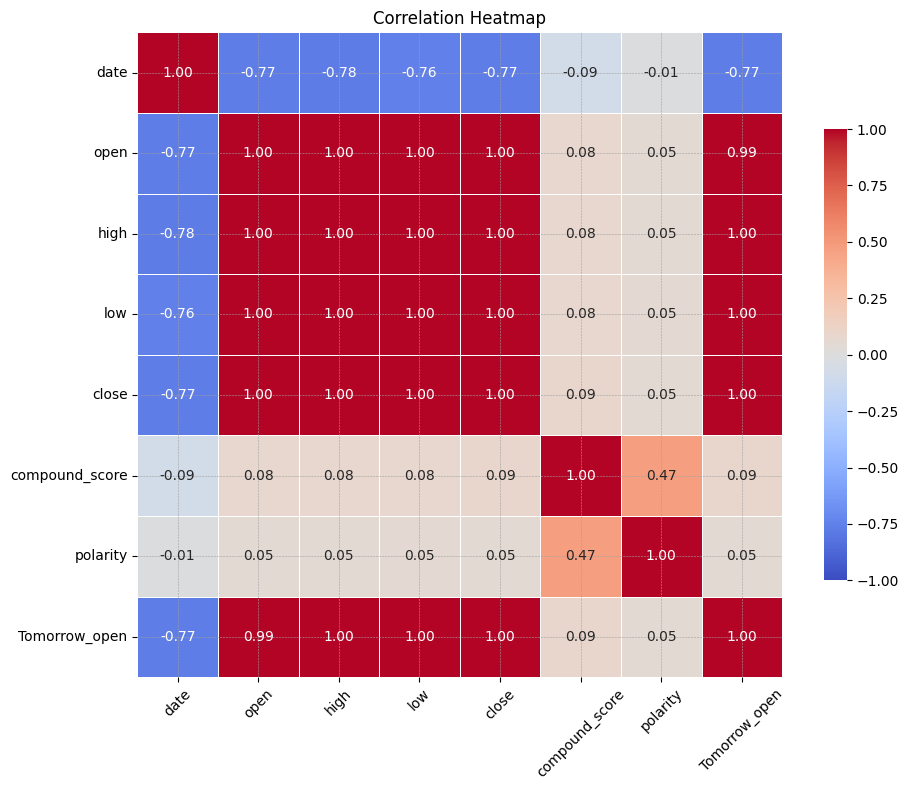

In [24]:
# Generate a correlation heatmap
cor = merged_df.corr() # Compute correlation matrix
plt.figure(figsize=(10, 8)) # Set up the matplotlib figure
sns.heatmap(cor, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

# Customize plot
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()# Show plot


In [25]:
merged_df.corr()

date      open      high       low     close  \
date            1.000000 -0.769107 -0.777708 -0.757616 -0.769281   
open           -0.769107  1.000000  0.998055  0.996517  0.995577   
high           -0.777708  0.998055  1.000000  0.996218  0.998000   
low            -0.757616  0.996517  0.996218  1.000000  0.997713   
close          -0.769281  0.995577  0.998000  0.997713  1.000000   
compound_score -0.085764  0.082903  0.084312  0.084560  0.086797   
polarity       -0.010748  0.048958  0.048164  0.054825  0.054025   
Tomorrow_open  -0.770803  0.994289  0.996899  0.996703  0.999111   

                compound_score  polarity  Tomorrow_open  
date                 -0.085764 -0.010748      -0.770803  
open                  0.082903  0.048958       0.994289  
high                  0.084312  0.048164       0.996899  
low                   0.084560  0.054825       0.996703  
close                 0.086797  0.054025       0.999111  
compound_score        1.000000  0.472263       0.089339  
polarity              0.472263  1.000000       0.052977  
Tomorrow_open         0.089339  0.052977       1.000000

# Creating new Dataframes for modelling
Creating two new DataFrames with_sentiment_df and no_sentiment_df from merged_df by dropping date column for with_sentiment_df and  'date' column and the Overall_Compound_Score' column for no_sentiment_df.


In [26]:
# Creating new dataframes
vader_sentiment_df = merged_df.loc[:, ['open', 'high', 'low', 'close', 'compound_score', 'Tomorrow_open']]
textblob_sentiment_df = merged_df.loc[:, ['open', 'high', 'low', 'close', 'polarity', 'Tomorrow_open']]
no_sentiment_df = merged_df.loc[:, ['open', 'high', 'low', 'close', 'Tomorrow_open']]

# Splitting dataset for training and testing
Defining a function named preprocessed to preprocess the data for a sequence model. This function takes a DataFrame df and a sequence_length parameter, normalizes the data, splits it into training and testing sets, creates sequences for training and testing, reshapes the input data to the required format for the model, and returns the preprocessed data along with the scaler used for normalization.

In [27]:
def preprocessed(df, sequence_length):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    # Split the data into train and test sets
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

    # Define function to create sequences
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:(i + sequence_length)])
            y.append(data[i + sequence_length])
        return np.array(X), np.array(y)

    # Create sequences for training and testing
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Reshape input data to be 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], df.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], df.shape[1]))

    return X_train, y_train, X_test, y_test, scaler

# Evaluating the model performance
*    The function evaluate(y_test, y_pred), evaluates the model's performance by calculating various metrics such as R2 score, mean absolute error (MAE), mean squared error (MSE), root mean squared error (RMSE), and mean absolute percentage error (MAPE).
*    The function Time_series_plot(y_test, y_pred) plots the original and predicted values for the 'Tomorrow_open' feature. It first inversely transforms the predictions and actual values to their original scale using the scaler object. Then, it extracts the 'Tomorrow_open' feature from both the original and predicted data and plots them on a line chart.

In [28]:
def evaluate(y_test, y_pred):
  # Evaluate the model
  r2_score = metrics.r2_score(y_test, y_pred)
  mae = metrics.mean_absolute_error(y_test, y_pred)
  mse = metrics.mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
  print("Final R2 Score:", round(r2_score, 4))
  print("MAE:", round(mae,4))
  print("MSE:", round(mse,4))
  print("RMSE:", round(rmse,4))

def Time_series_plot(y_test, y_pred):
    # Inverse transform predictions and actual values to original scale
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    # Extract Tomorrow_open feature from original and predicted data
    tomorrow_open_test = y_test_inv[:, -1]
    tomorrow_open_pred = y_pred_inv[:, -1]

    # Plot the original and predicted data for Tomorrow_open feature
    plt.figure(figsize=(10, 6))
    plt.plot(tomorrow_open_test, label='Original')
    plt.plot(tomorrow_open_pred, label='Predicted')
    plt.title('Original vs. Predicted Tomorrow_open Data')
    plt.xlabel('Time')
    plt.ylabel('Tomorrow_open Value')
    plt.legend()
    plt.show()


# Implementation of ML and DL Models
Implementation is done by using seven different ML and DL models such as Random Forest (RF) regression, Linear Regression (LR), K-Nearest Neighbors (KNN) Regression, XGBoost Regression Model, LSTM (Long Short-Term Memory) regression, GRU (Gated Recurrent Unit) regression, and Ensemble LR + GRU model

# Implementation of Random Forest Model
Implements Random Forest regression for predicting cryptocurrency prices by randomly selecting hyperparameters from a predefined set (param_dist) and evaluates the Random Forest model's performance using these hyperparameters. It repeats this process for a specified number of iterations (iterations) and selects the best-performing hyperparameters based on the R2 score. Trains the Random Forest model with the best hyperparameters and makes predictions on the test data. Finally evaluates the model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions.


Best Hyperparameters: {'n_estimators': 100, 'max_depth': None}
Final R2 Score: 0.386
MAE: 0.031
MSE: 0.0019
RMSE: 0.0437


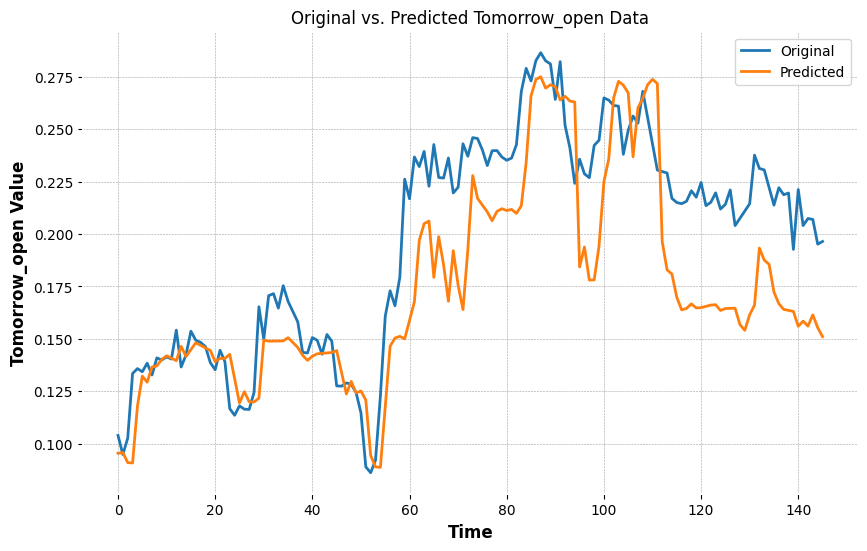

Best Hyperparameters: {'n_estimators': 150, 'max_depth': None}
Final R2 Score: 0.1724
MAE: 0.0287
MSE: 0.0017
RMSE: 0.0413


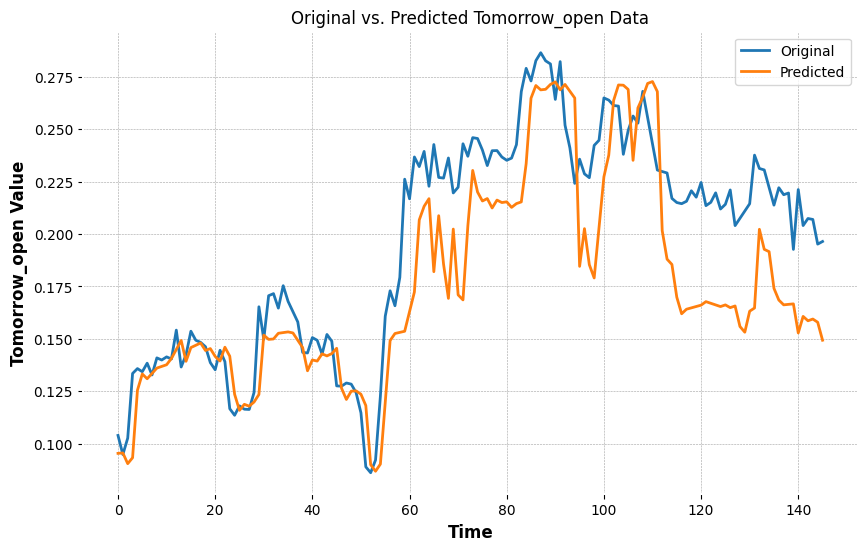

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 10}
Final R2 Score: 0.7544
MAE: 0.0185
MSE: 0.0007
RMSE: 0.0259


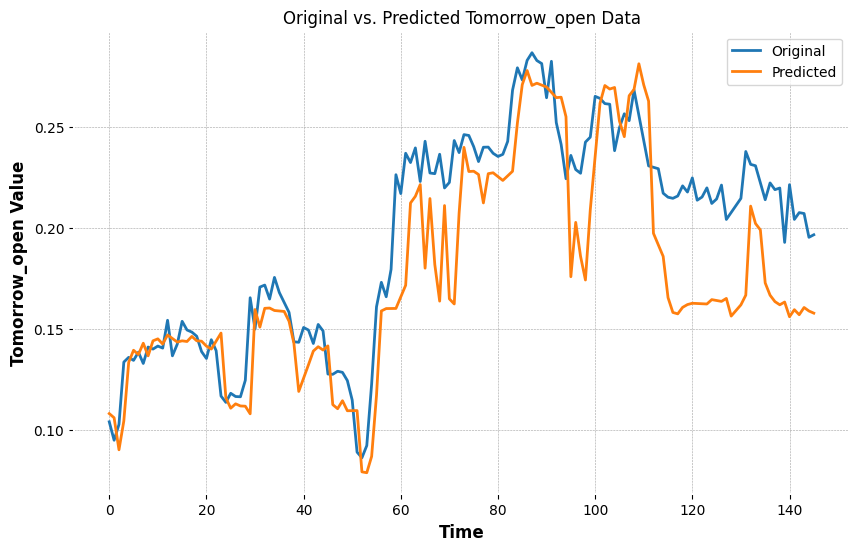

In [29]:
# Implementation of Random Forest
iterations = 20
sequence_length = 10
# Define hyperparameters
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20, 30]
}

def create_rf_model(n_estimators, max_depth):
    rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return rf_model

# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    rf_model = create_rf_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_rf_model = create_rf_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_rf_model.fit(X_train, y_train)
# Predictions on test data
y_pred_vrf = best_rf_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_vrf)
Time_series_plot(y_test,y_pred_vrf)

# Preprocess the sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    rf_model = create_rf_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_rf_model = create_rf_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_rf_model.fit(X_train, y_train)
# Predictions on test data
y_pred_trf = best_rf_model.predict(X_test)
# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_trf)
Time_series_plot(y_test,y_pred_trf)
# Preprocess the without sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    rf_model = create_rf_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params


# Train the model with the best hyperparameters
best_rf_model = create_rf_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_rf_model.fit(X_train, y_train)
# Predictions on test data
y_pred_rf = best_rf_model.predict(X_test)
# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_rf)
Time_series_plot(y_test,y_pred_rf)

# Implementation of Linear Regression Model
Implements Linear Regression for predicting cryptocurrency prices by iteratively training Linear Regression models and selecting the best-performing model based on the R2 score. Then rains the Linear Regression model and makes predictions on the test data. Finally evaluates the model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions with and without sentiment data.


Final R2 Score: 0.7768
MAE: 0.0138
MSE: 0.0007
RMSE: 0.0273


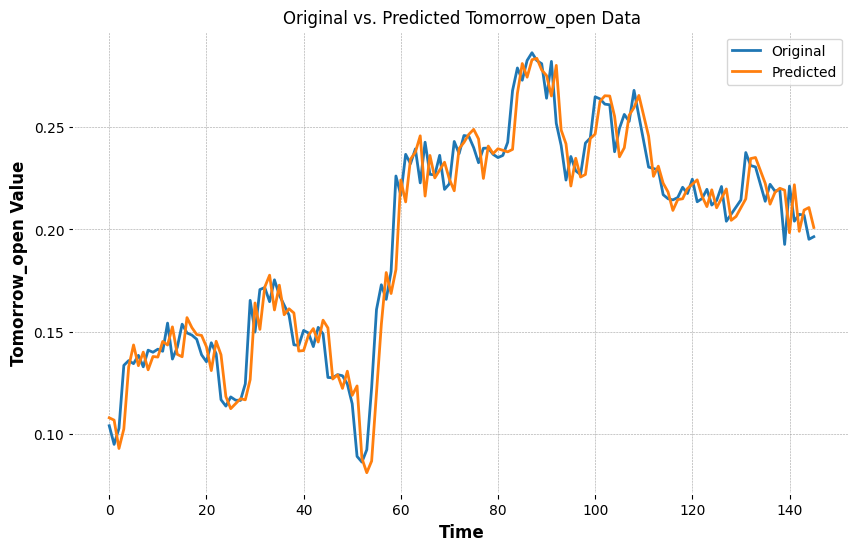

Final R2 Score: 0.7569
MAE: 0.0117
MSE: 0.0005
RMSE: 0.0216


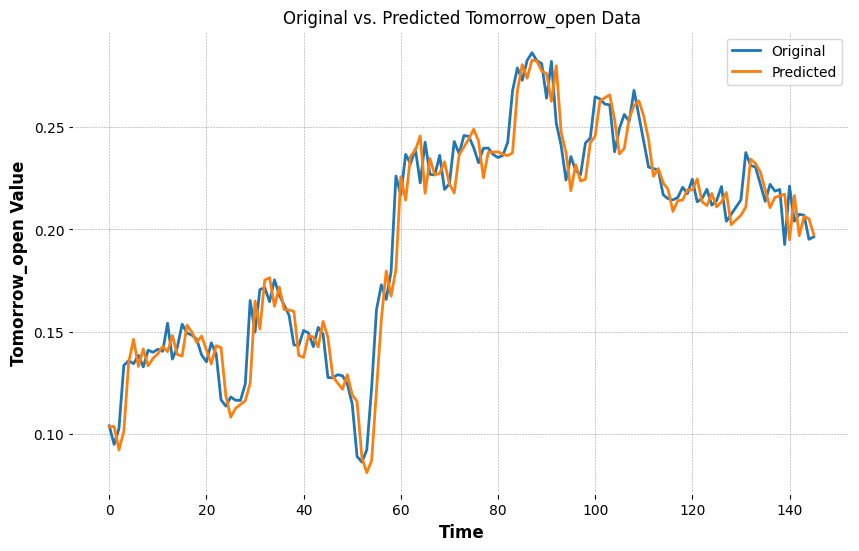

Final R2 Score: 0.9633
MAE: 0.0064
MSE: 0.0001
RMSE: 0.01


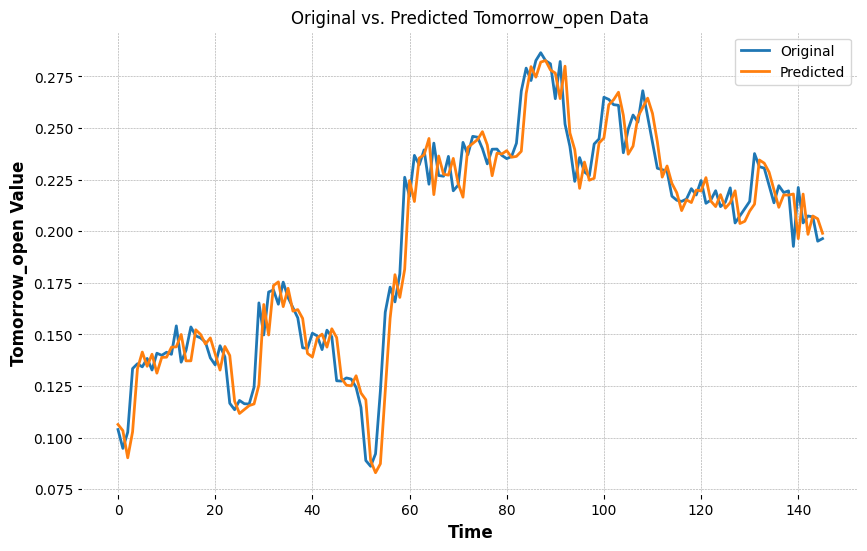

In [30]:
# Implementation of Linear Regression
iterations = 20
sequence_length = 10
def create_lr_model():
    lr_model = LinearRegression()
    return lr_model

# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_model = None
for _ in range(iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_lr_model = lr_model

# Predictions on test data using the best model
y_pred_vlr = best_lr_model.predict(X_test)
# Evaluate and print results
evaluate(y_test,y_pred_vlr)
Time_series_plot(y_test,y_pred_vlr)
# Preprocess the textblob sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_model = None
for _ in range(iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_lr_model = lr_model

# Predictions on test data using the best model
y_pred_tlr = best_lr_model.predict(X_test)
# Evaluate and print results
evaluate(y_test,y_pred_tlr)
Time_series_plot(y_test,y_pred_tlr)

# Preprocess the without sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
# Reshape X_trainx X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_model = None
for _ in range(iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_lr_model = lr_model

# Predictions on test data using the best model
y_pred_lr = best_lr_model.predict(X_test)
# Evaluate and print results
evaluate(y_test,y_pred_lr)
Time_series_plot(y_test,y_pred_lr)

# Implementation of KNN Regression Model
Implements K-Nearest Neighbors (KNN) Regression for predicting cryptocurrency prices by iterating over a specified number of iterations, training KNN Regression models with different numbers of neighbors (n_neighbors) and selecting the best-performing model based on the R2 score. Then trains the KNN Regression model with the best hyperparameters and makes predictions on the test data. Finally, evaluates the model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions for with and without sentiment data.

Best Hyperparameters: {'n_neighbors': 7}
Final R2 Score: 0.1672
MAE: 0.0356
MSE: 0.0026
RMSE: 0.0511


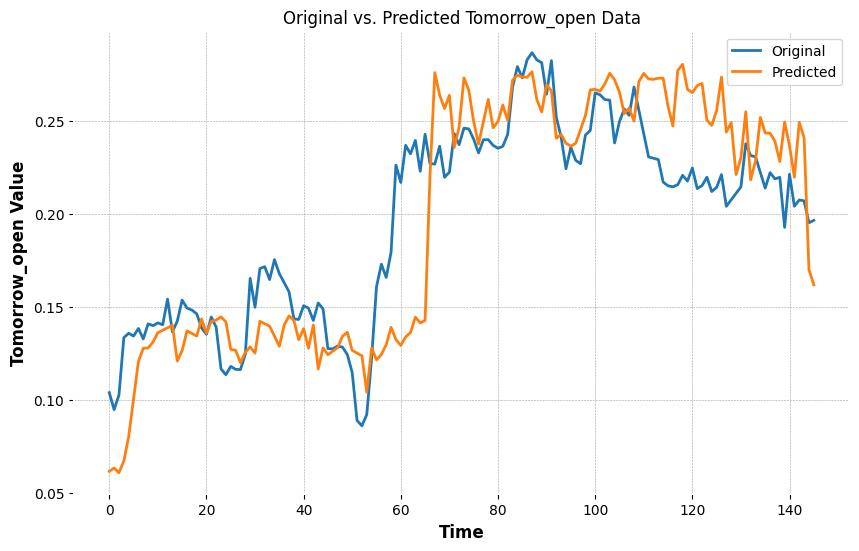

Best Hyperparameters: {'n_neighbors': 7}
Final R2 Score: 0.3309
MAE: 0.0293
MSE: 0.0015
RMSE: 0.0388


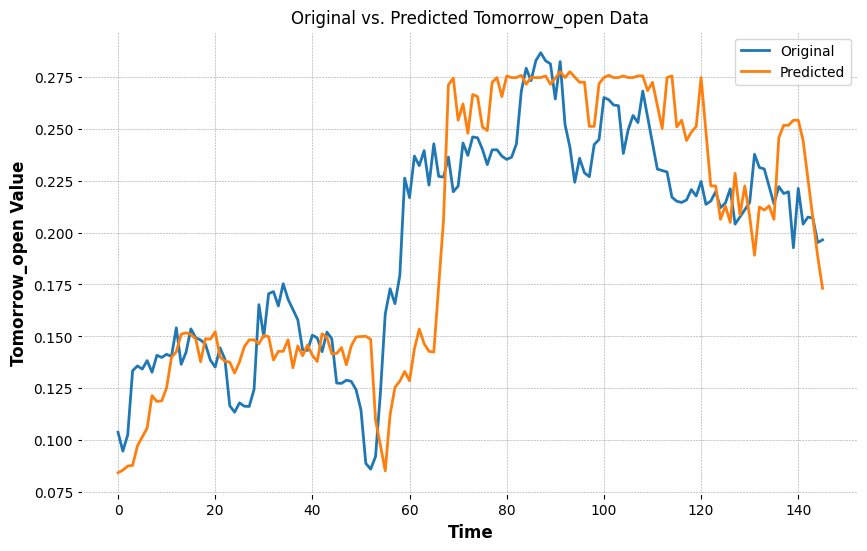

Best Hyperparameters: {'n_neighbors': 7}
Final R2 Score: 0.5328
MAE: 0.029
MSE: 0.0013
RMSE: 0.0356


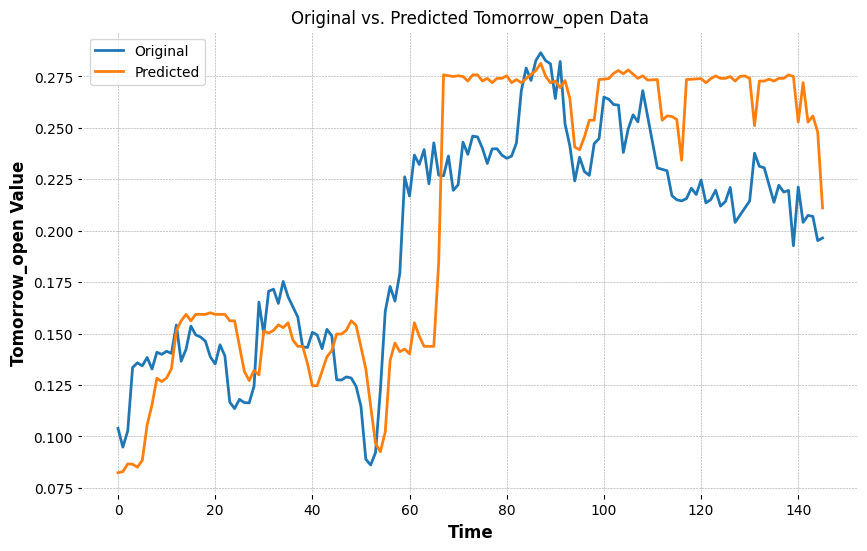

In [31]:
# Implementation of KNN Regression
iterations = 20
sequence_length = 10
# Define hyperparameters
param_dist = {
    "n_neighbors": [3, 5, 7]  # Number of neighbors to use
}
def create_knn_model(n_neighbors):
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
    return knn_model

# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    knn_model = create_knn_model(n_neighbors=params['n_neighbors'])
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_knn_model = create_knn_model(n_neighbors=best_params['n_neighbors'])
best_knn_model.fit(X_train, y_train)
# Predictions on test data
y_pred_vknn = best_knn_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_vknn)
Time_series_plot(y_test,y_pred_vknn)
# Preprocess the textblob sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    knn_model = create_knn_model(n_neighbors=params['n_neighbors'])
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_knn_model = create_knn_model(n_neighbors=best_params['n_neighbors'])
best_knn_model.fit(X_train, y_train)
# Predictions on test data
y_pred_tknn = best_knn_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_tknn)
Time_series_plot(y_test,y_pred_tknn)

# Preprocess the without sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train if necessary
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    knn_model = create_knn_model(n_neighbors=params['n_neighbors'])
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_knn_model = create_knn_model(n_neighbors=best_params['n_neighbors'])
best_knn_model.fit(X_train, y_train)
# Predictions on test data
y_pred_knn = best_knn_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_knn)
Time_series_plot(y_test,y_pred_knn)

# Implementation of XGBoost Regression Model
Implements XGBoost regression for predicting cryptocurrency prices by iteratively training XGBoost models with different hyperparameters (n_estimators and max_depth) and selecting the best-performing model based on the R2 score. Then trains the XGBoost model with the best hyperparameters and makes predictions on the test data. Finally, the model's performance is evaluated using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions for with and without sentiment data.


Best Hyperparameters: {'n_estimators': 50, 'max_depth': 6}
Final R2 Score: 0.1291
MAE: 0.0379
MSE: 0.0026
RMSE: 0.0507


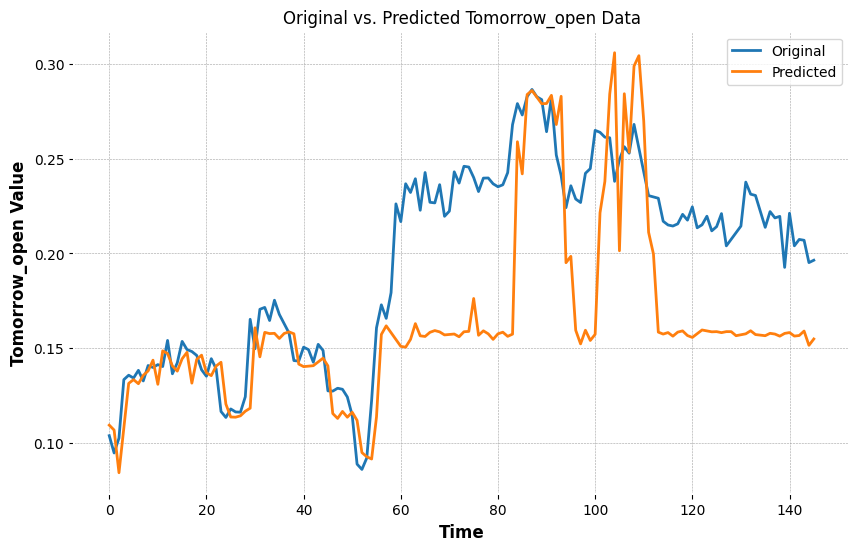

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 9}
Final R2 Score: 0.1135
MAE: 0.0353
MSE: 0.0022
RMSE: 0.0465


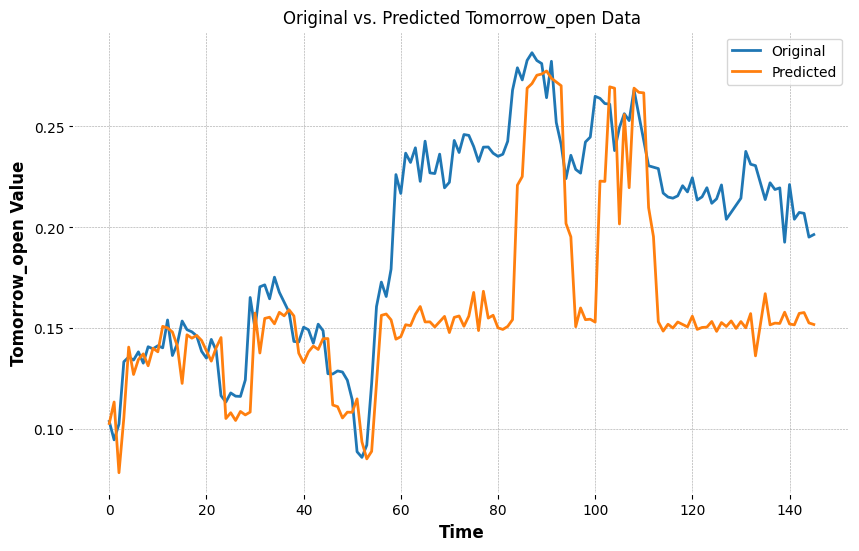

Best Hyperparameters: {'n_estimators': 50, 'max_depth': 3}
Final R2 Score: 0.2605
MAE: 0.0341
MSE: 0.002
RMSE: 0.0448


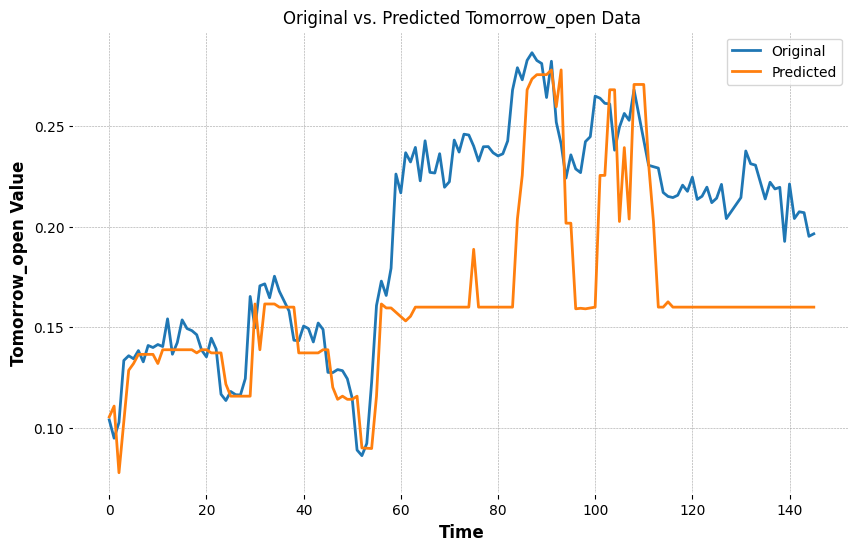

In [32]:
# Implementation of XGBoost

iterations = 20
sequence_length = 10
# Define hyperparameters
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 6, 9]
}

def create_xgb_model(n_estimators, max_depth):
    xgb_model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return xgb_model

# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    xgb_model = create_xgb_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_xgb_model = create_xgb_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_xgb_model.fit(X_train, y_train)
# Predictions on test data
y_pred_vxgb = best_xgb_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_vxgb)
Time_series_plot(y_test,y_pred_vxgb)
# Preprocess the textblob sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    xgb_model = create_xgb_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_xgb_model = create_xgb_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_xgb_model.fit(X_train, y_train)
# Predictions on test data
y_pred_txgb = best_xgb_model.predict(X_test)

# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_txgb)
Time_series_plot(y_test,y_pred_txgb)

# Preprocess the sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
# Reshape X_train, X_test and y_train
X_train_shape = X_train.shape
X_train = X_train.reshape(X_train_shape[0], -1)
y_train_shape = y_train.shape
y_train = y_train.reshape(y_train_shape[0], -1)
X_test_shape = X_test.shape
X_test = X_test.reshape(X_test_shape[0], -1)

best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    xgb_model = create_xgb_model(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params


# Train the model with the best hyperparameters
best_xgb_model = create_xgb_model(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_xgb_model.fit(X_train, y_train)
# Predictions on test data
y_pred_xgb = best_xgb_model.predict(X_test)
# Evaluate and print results
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_xgb)
Time_series_plot(y_test,y_pred_xgb)

# Implementation of LSTM Regression Model
Implements LSTM (Long Short-Term Memory) regression for predicting cryptocurrency prices by iteratively training LSTM models with different hyperparameters (units, dropout_rate, epochs, and batch_size) and selecting the best-performing model based on the R2 score. Create an LSTM model using the defined architecture with the best hyperparameters and train the LSTM model.
Makes predictions on the test data and evaluates the model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions. Finally, prints the best hyperparameters selected and the evaluation metrics for with and without sentiment data.

5/5 [==============================] - 0s 9ms/step
Best Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'epochs': 20, 'batch_size': 64}
Final R2 Score: 0.6361
MAE: 0.0245
MSE: 0.0011
RMSE: 0.0334


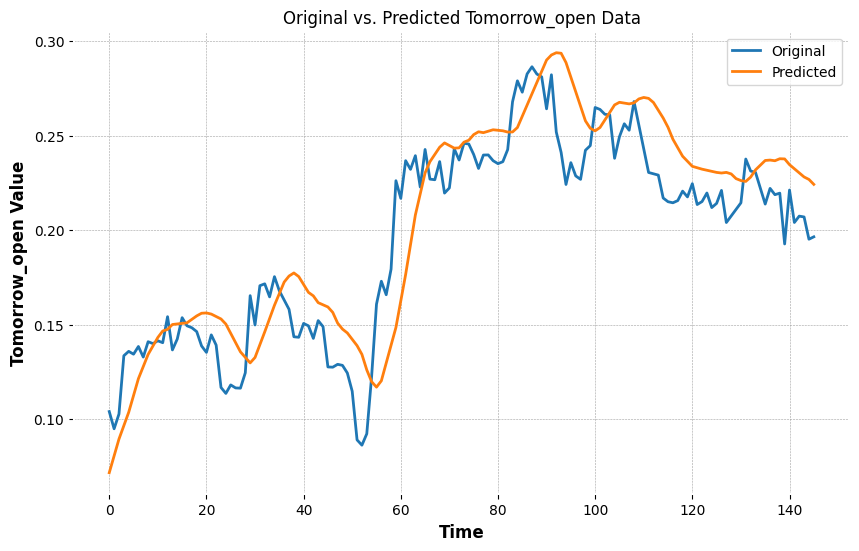

5/5 [==============================] - 0s 8ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.3, 'epochs': 20, 'batch_size': 32}
Final R2 Score: 0.2669
MAE: 0.0264
MSE: 0.0015
RMSE: 0.0386


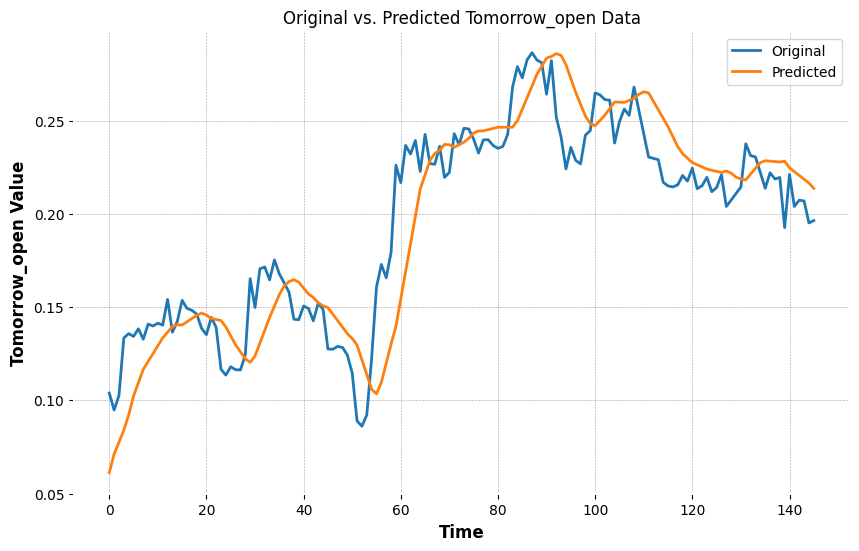

5/5 [==============================] - 1s 5ms/step
Best Hyperparameters: {'units': 100, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 32}
Final R2 Score: 0.7904
MAE: 0.0178
MSE: 0.0006
RMSE: 0.0239


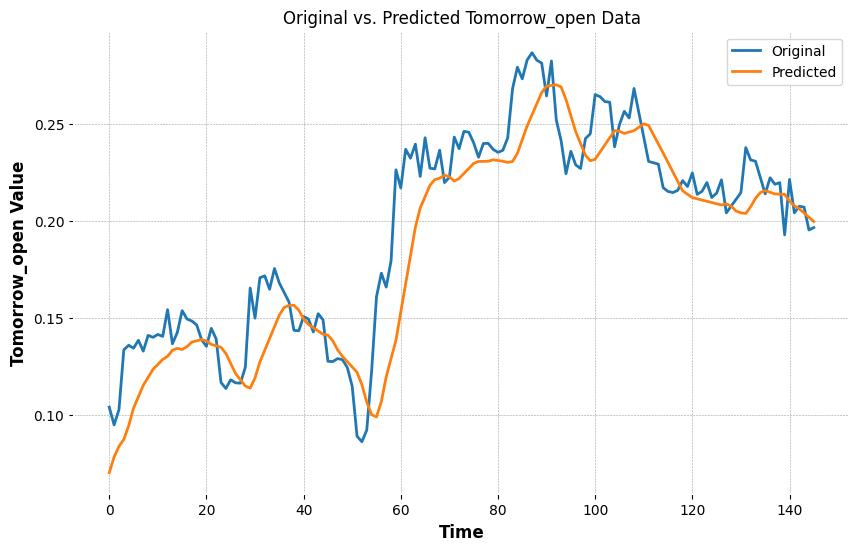

In [33]:
# Implementation of LSTM
iterations = 20
sequence_length = 10
# Define hyperparameters
param_dist = {
    "units": [50, 100, 150],
    "dropout_rate": [0.2, 0.3, 0.4],
    "epochs": [10, 20, 30],
    "batch_size": [32, 64, 128]
}
def create_lstm_model(units, dropout_rate, input_shape, num_features):
    inputs = Input(shape=input_shape)# Define input layer with Input(shape)
    lstm_output = LSTM(units=units, dropout=dropout_rate)(inputs) # LSTM layer
    outputs = Dense(num_features)(lstm_output) # Output layer
    model = Model(inputs=inputs, outputs=outputs) # Create model
    model.compile(optimizer='adam', loss='mse') # Compile model
    return model

# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
num_features = y_train.shape[1]
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))  # Ensure units is an integer
    num_features = y_train.shape[1]
    lstm_model = create_lstm_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    lstm_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = lstm_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params
# Train the model with the best hyperparameters
best_lstm_model = create_lstm_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
# Predictions on test data
y_pred_vlstm = best_lstm_model.predict(X_test)

print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_vlstm)
Time_series_plot(y_test,y_pred_vlstm)
# Preprocess the textblob sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
num_features = y_train.shape[1]
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))  # Ensure units is an integer
    num_features = y_train.shape[1]
    lstm_model = create_lstm_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    lstm_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = lstm_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params
# Train the model with the best hyperparameters
best_lstm_model = create_lstm_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
# Predictions on test data
y_pred_tlstm = best_lstm_model.predict(X_test)

print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_tlstm)
Time_series_plot(y_test,y_pred_tlstm)

# Preprocess the without sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
num_features = y_train.shape[1]
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))  # Ensure units is an integer
    num_features = y_train.shape[1]
    lstm_model = create_lstm_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    lstm_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = lstm_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params
# Train the model with the best hyperparameters
best_lstm_model = create_lstm_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_pred_lstm = best_lstm_model.predict(X_test)

print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_lstm)
Time_series_plot(y_test,y_pred_lstm)

# Implementation of GRU Regression Model
Implements the GRU (Gated Recurrent Unit) regression model for cryptocurrency price prediction by iteratively training GRU models with different hyperparameters (units, dropout_rate, epochs, and batch_size). It selects the best-performing model based on the R2 score. Create a GRU model using the best hyperparameters and trains the GRU model. Then make predictions on the test data and evaluates the model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions. Finally, the best hyperparameters selected and the evaluation metrics with and without sentiment data are printed.


5/5 [==============================] - 0s 4ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.2, 'epochs': 20, 'batch_size': 128}
Final R2 Score: 0.7265
MAE: 0.0193
MSE: 0.0009
RMSE: 0.0295


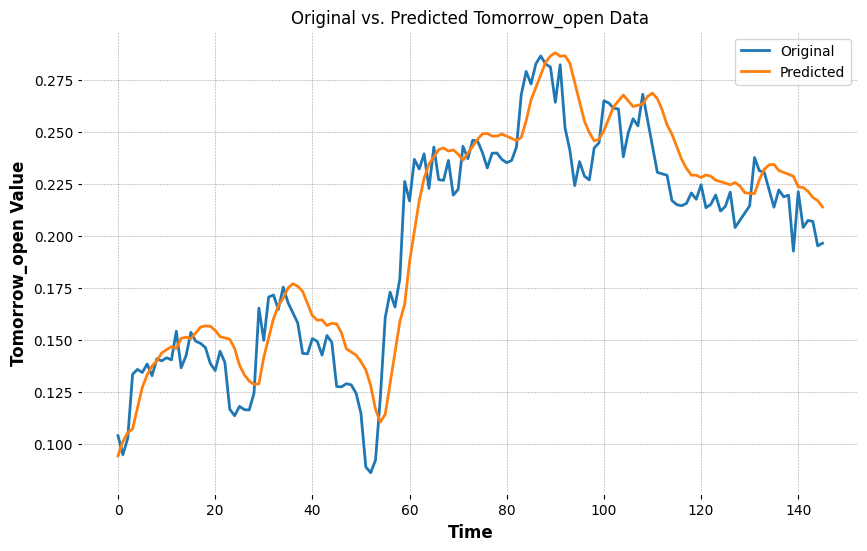

5/5 [==============================] - 0s 5ms/step
Best Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'epochs': 10, 'batch_size': 64}
Final R2 Score: 0.6443
MAE: 0.0186
MSE: 0.0007
RMSE: 0.0272


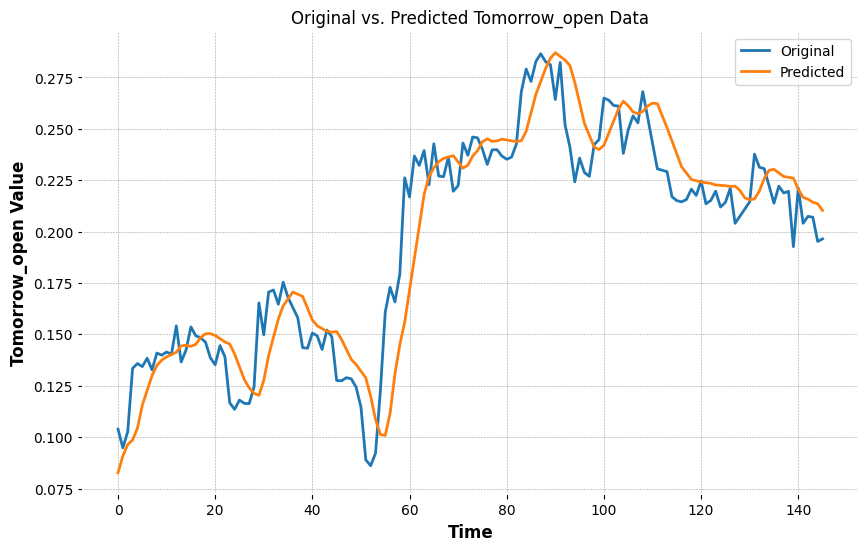

5/5 [==============================] - 0s 5ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 128}
Final R2 Score: 0.8707
MAE: 0.0145
MSE: 0.0004
RMSE: 0.0187


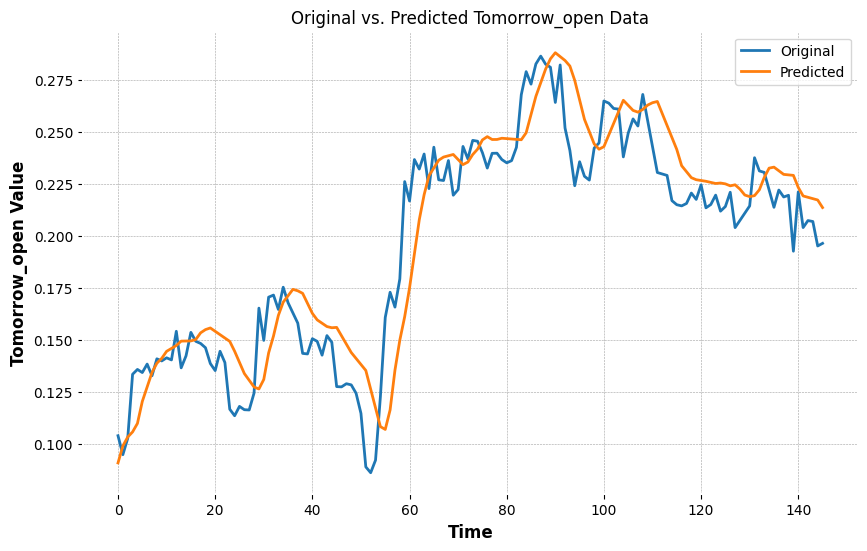

In [34]:
#Implemenation of GRU

iterations = 20
sequence_length = 10
# Define hyperparameters
param_dist = {
    "units": [50, 100, 150],
    "dropout_rate": [0.2, 0.3, 0.4],
    "epochs": [10, 20, 30],
    "batch_size": [32, 64, 128]
}

def create_gru_model(units, dropout_rate, input_shape, num_features):
    inputs = Input(shape=input_shape)
    gru_output = GRU(units=units, dropout=dropout_rate)(inputs)
    outputs = Dense(num_features)(gru_output)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model
# Preprocess the vader sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))
    num_features = y_train.shape[1]
    gru_model = create_gru_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    gru_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = gru_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_gru_model = create_gru_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_gru_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
# Predictions on test data
y_pred_vgru = best_gru_model.predict(X_test)

print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_vgru)
Time_series_plot(y_test,y_pred_vgru)

# Preprocess the textblob sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))
    num_features = y_train.shape[1]
    gru_model = create_gru_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    gru_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = gru_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_gru_model = create_gru_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_gru_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
# Predictions on test data
y_pred_tgru = best_gru_model.predict(X_test)

print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_tgru)
Time_series_plot(y_test,y_pred_tgru)

# Preprocess the without sentiment data
X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
best_score = float('-inf')
best_params = None
for _ in range(iterations):
    params = {key: np.random.choice(value) for key, value in param_dist.items()}
    input_shape = (X_train.shape[1], X_train.shape[2])
    units = int(np.random.choice(param_dist['units']))
    num_features = y_train.shape[1]
    gru_model = create_gru_model(units=units, dropout_rate=params['dropout_rate'], input_shape=input_shape, num_features=num_features)
    gru_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    y_pred = gru_model.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

# Train the model with the best hyperparameters
best_gru_model = create_gru_model(units=units, dropout_rate=best_params['dropout_rate'], input_shape=input_shape, num_features=num_features)
best_gru_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Predictions on test data
y_pred_gru = best_gru_model.predict(X_test)
print("Best Hyperparameters:", best_params)
evaluate(y_test,y_pred_gru)
Time_series_plot(y_test,y_pred_gru)


# Implemetation of Ensembled LR + GRU Model
Implements an ensemble model combining Linear Regression (LR) and GRU (Gated Recurrent Unit) models for cryptocurrency price prediction which improve prediction accuracy by leverages the strengths of both LR and GRU models. It iterates over a specified number of iterations (lr_iterations and gru_iterations) and trains LR and GRU models with different hyperparameters and selects the best-performing LR and GRU models based on the R2 score. It creates LR and GRU models with the best hyperparameters and trains the LR and GRU models. Finally, it combines the predictions of the LR and GRU models by averaging them and evaluates the ensemble model's performance using various metrics and visualizes the predictions using the evaluate and Time_series_plot functions.


5/5 [==============================] - 0s 3ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 128}
Final R2 Score: 0.764
MAE: 0.017
MSE: 0.0008
RMSE: 0.0276
5/5 [==============================] - 0s 4ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 128}
Final R2 Score: 0.7454
MAE: 0.015
MSE: 0.0005
RMSE: 0.0228
5/5 [==============================] - 0s 3ms/step
Best Hyperparameters: {'units': 150, 'dropout_rate': 0.2, 'epochs': 30, 'batch_size': 128}
Final R2 Score: 0.9266
MAE: 0.0103
MSE: 0.0002
RMSE: 0.0141


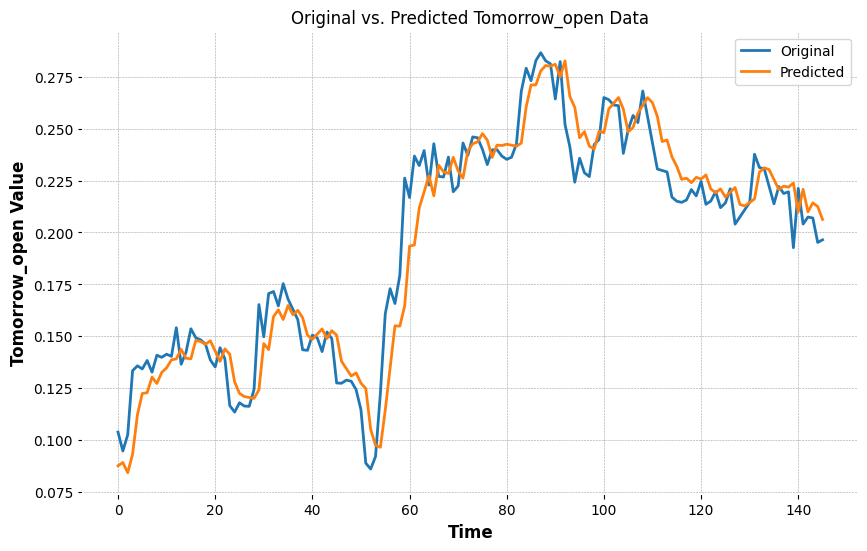

In [35]:
#Implemetation of Ensembled LR + GRU

# Define parameters
iterations = 20
lr_iterations = 20
gru_iterations = 20
sequence_length = 10

# Define hyperparameters
param_dist = {
    "units": [50, 100, 150],
    "dropout_rate": [0.2, 0.3, 0.4],
    "epochs": [10, 20, 30],
    "batch_size": [32, 64, 128]
}
# Define function to create LR model
def create_lr_model():
    lr_model = LinearRegression()
    return lr_model

# Define function to create GRU model
def create_gru_model(units, dropout_rate, input_shape, num_features):
    inputs = Input(shape=input_shape)
    gru_output = GRU(units=units, dropout=dropout_rate)(inputs)
    outputs = Dense(num_features)(gru_output)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Preprocess the vader sentiment data
X_train_sent, y_train_sent, X_test_sent, y_test_vsent, scaler_sent = preprocessed(vader_sentiment_df, sequence_length)
# Flatten the features for each sample in X_test_sent
X_train_sent_flat = X_train_sent.reshape(X_train_sent.shape[0], -1)
X_test_sent_flat = X_test_sent.reshape(X_test_sent.shape[0], -1)
# Reshape input data to have three dimensions
X_train_sent_reshaped = X_train_sent_flat.reshape(X_train_sent_flat.shape[0], 1, X_train_sent_flat.shape[1])
X_test_sent_reshaped = X_test_sent_flat.reshape(X_test_sent_flat.shape[0], 1, X_test_sent_flat.shape[1])

# Train LR model and select the best LR model
best_lr_score = float('-inf')
best_lr_model = None
for _ in range(lr_iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train_sent_flat, y_train_sent)
    y_pred_lr = lr_model.predict(X_test_sent_flat)
    score_lr = r2_score(y_test_vsent, y_pred_lr)
    if score_lr > best_lr_score:
        best_lr_score = score_lr
        best_lr_model = lr_model

# Train GRU model and select the best GRU model
best_gru_score = float('-inf')
best_gru_model = None
for _ in range(gru_iterations):
    gru_model = create_gru_model(units=100, dropout_rate=best_params['dropout_rate'], input_shape=(X_train_sent_reshaped.shape[1], X_train_sent_reshaped.shape[2]), num_features=y_train_sent.shape[1])
    gru_model.fit(X_train_sent_reshaped, y_train_sent, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    y_pred_gru = gru_model.predict(X_test_sent_reshaped)
    score_gru = r2_score(y_test_vsent, y_pred_gru)
    if score_gru > best_gru_score:
        best_gru_score = score_gru
        best_gru_model = gru_model

# Combine predictions of LR and GRU models
y_pred_ensemble_lr = best_lr_model.predict(X_test_sent_flat)
y_pred_ensemble_gru = best_gru_model.predict(X_test_sent_reshaped)
y_pred_vader_ensemble = (y_pred_ensemble_lr + y_pred_ensemble_gru) / 2

# Evaluate and print results for ensemble model
print("Best Hyperparameters:", best_params)
evaluate(y_test_vsent, y_pred_vader_ensemble)

# Preprocess the textblob sentiment data
X_train_sent, y_train_sent, X_test_sent, y_test_tsent, scaler_sent = preprocessed(textblob_sentiment_df, sequence_length)
# Flatten the features for each sample in X_test_sent
X_train_sent_flat = X_train_sent.reshape(X_train_sent.shape[0], -1)
X_test_sent_flat = X_test_sent.reshape(X_test_sent.shape[0], -1)
# Reshape input data to have three dimensions
X_train_sent_reshaped = X_train_sent_flat.reshape(X_train_sent_flat.shape[0], 1, X_train_sent_flat.shape[1])
X_test_sent_reshaped = X_test_sent_flat.reshape(X_test_sent_flat.shape[0], 1, X_test_sent_flat.shape[1])

# Train LR model and select the best LR model
best_lr_score = float('-inf')
best_lr_model = None
for _ in range(lr_iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train_sent_flat, y_train_sent)
    y_pred_lr = lr_model.predict(X_test_sent_flat)
    score_lr = r2_score(y_test_tsent, y_pred_lr)
    if score_lr > best_lr_score:
        best_lr_score = score_lr
        best_lr_model = lr_model

# Train GRU model and select the best GRU model
best_gru_score = float('-inf')
best_gru_model = None
for _ in range(gru_iterations):
    gru_model = create_gru_model(units=100, dropout_rate=best_params['dropout_rate'], input_shape=(X_train_sent_reshaped.shape[1], X_train_sent_reshaped.shape[2]), num_features=y_train_sent.shape[1])
    gru_model.fit(X_train_sent_reshaped, y_train_sent, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    y_pred_gru = gru_model.predict(X_test_sent_reshaped)
    score_gru = r2_score(y_test_tsent, y_pred_gru)
    if score_gru > best_gru_score:
        best_gru_score = score_gru
        best_gru_model = gru_model

# Combine predictions of LR and GRU models
y_pred_ensemble_lr = best_lr_model.predict(X_test_sent_flat)
y_pred_ensemble_gru = best_gru_model.predict(X_test_sent_reshaped)
y_pred_textblob_ensemble = (y_pred_ensemble_lr + y_pred_ensemble_gru) / 2

# Evaluate and print results for ensemble model
print("Best Hyperparameters:", best_params)
evaluate(y_test_tsent, y_pred_textblob_ensemble)

# Preprocess the without sentiment data
X_train_no_sent, y_train_no_sent, X_test_no_sent, y_test_no_sent, scaler_no_sent = preprocessed(no_sentiment_df, sequence_length)
# Flatten the features for each sample in X_test_sent
X_train_no_sent_flat = X_train_no_sent.reshape(X_train_no_sent.shape[0], -1)
X_test_no_sent_flat = X_test_no_sent.reshape(X_test_no_sent.shape[0], -1)
# Reshape input data to have three dimensions
X_train_no_sent_reshaped = X_train_no_sent_flat.reshape(X_train_no_sent_flat.shape[0], 1, X_train_no_sent_flat.shape[1])
X_test_no_sent_reshaped = X_test_no_sent_flat.reshape(X_test_no_sent_flat.shape[0], 1, X_test_no_sent_flat.shape[1])

# Train LR model and select the best LR model
best_lr_score = float('-inf')
best_lr_model = None
for _ in range(lr_iterations):
    lr_model = create_lr_model()
    lr_model.fit(X_train_no_sent_flat, y_train_no_sent)
    y_pred_lr = lr_model.predict(X_test_no_sent_flat)
    score_lr = r2_score(y_test_no_sent, y_pred_lr)
    if score_lr > best_lr_score:
        best_lr_score = score_lr
        best_lr_model = lr_model

# Train GRU model and select the best GRU model
best_gru_score = float('-inf')
best_gru_model = None
for _ in range(gru_iterations):
    gru_model = create_gru_model(units=100, dropout_rate=best_params['dropout_rate'], input_shape=(X_train_no_sent_reshaped.shape[1], X_train_no_sent_reshaped.shape[2]), num_features=y_train_no_sent.shape[1])
    gru_model.fit(X_train_no_sent_reshaped, y_train_no_sent, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    y_pred_gru = gru_model.predict(X_test_no_sent_reshaped)
    score_gru = r2_score(y_test_no_sent, y_pred_gru)
    if score_gru > best_gru_score:
        best_gru_score = score_gru
        best_gru_model = gru_model

# Combine predictions of LR and GRU models
y_pred_ensemble_lr = best_lr_model.predict(X_test_no_sent_flat)
y_pred_ensemble_gru = best_gru_model.predict(X_test_no_sent_reshaped)
y_pred_no_sent_ensemble = (y_pred_ensemble_lr + y_pred_ensemble_gru) / 2

# Evaluate and print results for ensemble model
print("Best Hyperparameters:", best_params)
evaluate(y_test_no_sent, y_pred_no_sent_ensemble)
Time_series_plot(y_test_no_sent, y_pred_no_sent_ensemble)

# Performance Comparision of all models
Compares the performance of different models for both sentiment and non-sentiment data using R-squared (R2) scores. It calculates the R2 scores for each model's predictions on both sentiment and non-sentiment data. Then creates a bar plot to visualize the R2 scores of each model for both sentiment and non-sentiment data.


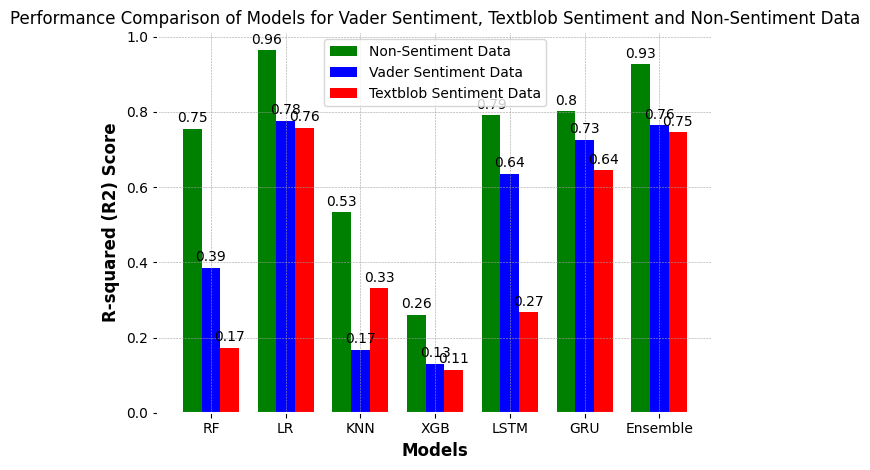

In [36]:
#Performance Comparision of all models
X_train, y_train, X_test, y_test, scaler = preprocessed(vader_sentiment_df, sequence_length)
# R-squared scores for vader sentiment data
r2_rf_vader = metrics.r2_score(y_test, y_pred_vrf)
r2_lr_vader = metrics.r2_score(y_test, y_pred_vlr)
r2_knn_vader = metrics.r2_score(y_test, y_pred_vknn)
r2_xgb_vader = metrics.r2_score(y_test, y_pred_vxgb)
r2_lstm_vader= metrics.r2_score(y_test, y_pred_vlstm)
r2_gru_vader = metrics.r2_score(y_test, y_pred_vgru)
r2_ensemble_vader = metrics.r2_score(y_test_vsent, y_pred_vader_ensemble)


X_train, y_train, X_test, y_test, scaler = preprocessed(textblob_sentiment_df, sequence_length)
# R-squared scores for textblob sentiment data
r2_rf_textblob = metrics.r2_score(y_test, y_pred_trf)
r2_lr_textblob = metrics.r2_score(y_test, y_pred_tlr)
r2_knn_textblob = metrics.r2_score(y_test, y_pred_tknn)
r2_xgb_textblob = metrics.r2_score(y_test, y_pred_txgb)
r2_lstm_textblob = metrics.r2_score(y_test, y_pred_tlstm)
r2_gru_textblob = metrics.r2_score(y_test, y_pred_tgru)
r2_ensemble_textblob = metrics.r2_score(y_test_tsent, y_pred_textblob_ensemble)

X_train, y_train, X_test, y_test, scaler = preprocessed(no_sentiment_df, sequence_length)
# R-squared scores for non-sentiment data
r2_rf_no_sentiment = metrics.r2_score(y_test, y_pred_rf)
r2_lr_no_sentiment = metrics.r2_score(y_test, y_pred_lr)
r2_knn_no_sentiment = metrics.r2_score(y_test, y_pred_knn)
r2_xgb_no_sentiment = metrics.r2_score(y_test, y_pred_xgb)
r2_lstm_no_sentiment = metrics.r2_score(y_test, y_pred_lstm)
r2_gru_no_sentiment = metrics.r2_score(y_test, y_pred_gru)
r2_ensemble_no_sentiment = metrics.r2_score(y_test_no_sent, y_pred_no_sent_ensemble)

# Models and R-squared scores for vader sentiment data
models_vader = ['RF', 'LR', 'KNN', 'XGB', 'LSTM', 'GRU', 'Ensemble']
r2_values_vader = [r2_rf_vader, r2_lr_vader, r2_knn_vader, r2_xgb_vader, r2_lstm_vader, r2_gru_vader, r2_ensemble_vader]
# Models and R-squared scores for sentiment data
models_textblob = ['RF', 'LR', 'KNN', 'XGB', 'LSTM', 'GRU', 'Ensemble']
r2_values_textblob = [r2_rf_textblob, r2_lr_textblob, r2_knn_textblob, r2_xgb_textblob, r2_lstm_textblob, r2_gru_textblob, r2_ensemble_textblob]
# Models and R-squared scores for non-sentiment data
models_no_sentiment = ['RF', 'LR', 'KNN', 'XGB', 'LSTM', 'GRU','Ensemble']
r2_values_no_sentiment = [r2_rf_no_sentiment, r2_lr_no_sentiment, r2_knn_no_sentiment, r2_xgb_no_sentiment, r2_lstm_no_sentiment, r2_gru_no_sentiment, r2_ensemble_no_sentiment]

# Define the width of each bar
bar_width = 0.25

# Define the x positions for the bars
x_no_sentiment = range(len(models_no_sentiment))
x_vader = [x + bar_width for x in x_no_sentiment]
x_textblob = [x + 2*bar_width for x in x_no_sentiment]

# Plot R-squared scores for non-sentiment data
plt.bar(x_no_sentiment, r2_values_no_sentiment, width=bar_width, color='green', label='Non-Sentiment Data')
# Plot R-squared scores for vader sentiment data
plt.bar(x_vader, r2_values_vader, width=bar_width, color='blue', label='Vader Sentiment Data')
# Plot R-squared scores for textblob sentiment data
plt.bar(x_textblob, r2_values_textblob, width=bar_width, color='red', label='Textblob Sentiment Data')

# Add text labels with the R-squared scores for vader sentiment data
for i, v in zip(x_vader, r2_values_vader):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)
# Add text labels with the R-squared scores for textblob sentiment data
for i, v in zip(x_textblob, r2_values_textblob):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)
# Add text labels with the R-squared scores for non-sentiment data
for i, v in zip(x_no_sentiment, r2_values_no_sentiment):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

# Set x-axis labels and tick labels
plt.xlabel('Models')
plt.ylabel('R-squared (R2) Score')
plt.title('Performance Comparison of Models for Vader Sentiment, Textblob Sentiment and Non-Sentiment Data')
plt.xticks([x + bar_width for x in range(len(models_no_sentiment))], models_no_sentiment)
plt.legend()
plt.tight_layout()
plt.show()



# Pickling
The sentiment data is trained using AI model which is then saved as pickle file using pickle.dump() to serialize. This pickled file is then loaded in the Flask web page application to get cryptocurrency prediction.  

In [37]:
with open('vader_ensemble_model.pkl', 'wb') as f:
    pickle.dump((best_lr_model, best_gru_model), f)

# Buy/Sell Analysis using the Predicted price of Ensemble model
Based on sentiment analysis and the ensemble model, the predicted tomorrow's open price is generated. It creates a DataFrame sentiment_comparison_df containing the predicted open prices for sentiment data using the ensemble model. Based on the sentiment analysis (Overall_Sentiment), it calculates the predicted tomorrow's open price.The function buy_sell(op, cl) to determine whether to buy or sell based on the Tomorrows's opening and closing prices. If the closing price (cl) is greater than the opening price (op), the function returns Sell otherwise Buy. Applying the Function to Actual and Predicted Data to get "Buy-(Actual)" and "Buy-(Predicted)", representing the buy/sell decisions based on actual and predicted data, respectively.


In [38]:
# Create a DataFrame for sentiment comparison with both predicted prices
sentiment_comparison_df = pd.DataFrame({
    'Predicted_vader_price': y_pred_vader_ensemble.flatten(),  # Predicted open prices using Vader ensemble
    'Predicted_textblob_price': y_pred_textblob_ensemble.flatten()  # Predicted open prices using TextBlob ensemble
})

# Buy or Sell Analysis function
def buy_sell(open, close):
    if open > close:
        return 'Buy'
    else:
        return 'Sell'

# Merge sentiment analysis results with main DataFrame Final_df
Final_df = Final_df.reset_index(drop=True)

# Predicted prices and tomorrow's open prices using the Vader model
Final_df['Predicted_vader'] = sentiment_comparison_df['Predicted_vader_price']
Final_df.loc[Final_df['sentiment_vader'] == 'neutral', 'Predicted_vader'] += Final_df['Tomorrow_open']
Final_df.loc[Final_df['sentiment_vader'] == 'positive', 'Predicted_vader'] += Final_df['Tomorrow_open'] + sentiment_comparison_df['Predicted_vader_price']
Final_df.loc[Final_df['sentiment_vader'] == 'negative', 'Predicted_vader'] += Final_df['Tomorrow_open'] - sentiment_comparison_df['Predicted_vader_price']
# Predicted prices and tomorrow's open prices using the TextBlob model
Final_df['Predicted_textblob'] = sentiment_comparison_df['Predicted_textblob_price']
Final_df.loc[Final_df['sentiment_textblob'] == 'neutral', 'Predicted_textblob'] += Final_df['Tomorrow_open']
Final_df.loc[Final_df['sentiment_textblob'] == 'positive', 'Predicted_textblob'] += Final_df['Tomorrow_open'] + sentiment_comparison_df['Predicted_textblob_price']
Final_df.loc[Final_df['sentiment_textblob'] == 'negative', 'Predicted_textblob'] += Final_df['Tomorrow_open'] - sentiment_comparison_df['Predicted_textblob_price']
# Calculate buy/sell signals for actual and predicted prices
Final_df["Buy-Actual"] = list(map(buy_sell, Final_df['Tomorrow_open'], Final_df['close']))
Final_df["Buy-Vader_Predicted"] = list(map(buy_sell, Final_df['Predicted_vader'], Final_df['close']))
Final_df["Buy-Textblob_Predicted"] = list(map(buy_sell, Final_df['Predicted_textblob'], Final_df['close']))
Final_df

date        open        high         low       close  \
0   2021-02-01  33138.7765  34715.6557  32341.9899  33613.3208   
1   2021-02-02  33525.2882  36008.3108  33437.7469  35632.9020   
2   2021-02-03  35519.7078  37505.3037  35416.7318  37397.4264   
3   2021-02-04  37645.9456  38731.0880  36207.4943  37256.2521   
4   2021-02-05  36970.8123  38332.4169  36637.6456  37851.5966   
..         ...         ...         ...         ...         ...   
773 2023-06-07  27213.7657  27289.4498  26140.2145  26242.9491   
774 2023-06-08  26323.8511  26717.8448  26225.8423  26600.3653   
775 2023-06-09  26498.5902  26770.2167  26319.0688  26460.5807   
776 2023-06-10  26475.2106  26522.0733  25449.2555  25950.5441   
777 2023-06-11  25865.7598  26218.0278  25671.2924  25809.0986   

    sentiment_vader sentiment_textblob  compound_score  polarity  \
0           neutral            neutral        0.163157  0.014044   
1          positive           positive        0.374750  0.000833   
2          positive           positive        0.415050  0.100000   
3          positive            neutral        0.232633 -0.025000   
4          positive           positive        0.254378  0.113717   
..              ...                ...             ...       ...   
773        positive           positive        0.315852  0.131909   
774        positive           positive        0.202759  0.107849   
775        positive           positive        0.372647  0.131593   
776        positive           positive        0.264084  0.101433   
777        positive           positive        0.385339  0.060175   

     Tomorrow_open  Predicted_vader  Predicted_textblob Buy-Actual  \
0       33525.2882     33525.378672        33525.372655       Sell   
1       35519.7078     35519.870919        35519.876107       Sell   
2       37645.9456     37646.119759        37646.118178        Buy   
3       36970.8123     36970.991861        36970.895186       Sell   
4       38305.2754     38306.398336        38306.435312        Buy   
..             ...              ...                 ...        ...   
773     26323.8511     26324.282623        26324.280922        Buy   
774     26498.5902     26499.016953        26499.020563       Sell   
775     26475.2106     26475.635216        26475.641957        Buy   
776     25865.7598     25866.184426        25866.182954       Sell   
777     25930.9289     25931.359645        25931.356315        Buy   

    Buy-Vader_Predicted Buy-Textblob_Predicted  
0                  Sell                   Sell  
1                  Sell                   Sell  
2                   Buy                    Buy  
3                  Sell                   Sell  
4                   Buy                    Buy  
..                  ...                    ...  
773                 Buy                    Buy  
774                Sell                   Sell  
775                 Buy                    Buy  
776                Sell                   Sell  
777                 Buy                    Buy  

[778 rows x 15 columns]

# Calculating Buy or Sell accuracy
The code calculates the buy and sell accuracies based on the confusion matrix (cm) obtained from comparing the buy/sell decisions made using actual and predicted data. The buy accuracy, sell accuracy and overall buy-sell accuracy is calculated. The buy accuracy, sell accuracy, and overall buy-sell accuracy are printed. A heatmap of the confusion matrix is plotted using seaborn's heatmap function which displays the distribution of correct and incorrect predictions.

Buy Accuracy: 0.9973
Sell Accuracy: 1.0
Overall Buy-Sell Accuracy:  0.9987


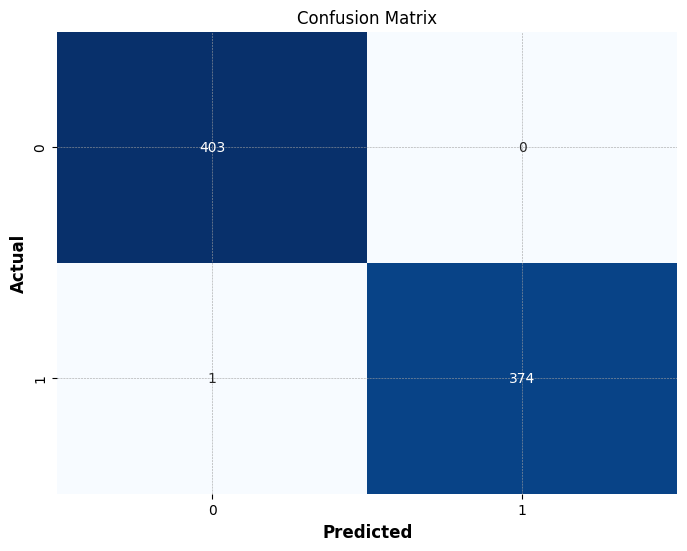

In [39]:
def accuracy():
    # Calculate accuracy for buying predictions
    buy_accuracy = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True Positives / (False Negatives + True Positives)
    # Calculate accuracy for selling predictions
    sell_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negatives / (True Negatives + False Positives)
    Accuracy = cm.diagonal().sum()/cm.sum()

    print("Buy Accuracy:", round(buy_accuracy,4))
    print("Sell Accuracy:", round(sell_accuracy,4))
    print("Overall Buy-Sell Accuracy: ", round(Accuracy,4))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#Calculating Buy or Sell accuracy for Vader
cm = confusion_matrix(Final_df['Buy-Actual'], Final_df['Buy-Vader_Predicted'])
accuracy()